In [89]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab
import math
import seaborn as sns
import pmdarima as pm
import hvplot as hv
import warnings
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from numpy.random import normal, seed
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [59]:
file_path = Path('XOM.csv')

In [61]:
df_xom = pd.read_csv(file_path, sep=',')

In [63]:
df_xom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3782 non-null   object 
 1   Price   3782 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.2+ KB


In [65]:
df_crude_oil = pd.read_csv('Crude_Oil_CLF.csv', sep=',')

In [67]:
df_crude_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3781 non-null   object 
 1   Price   3781 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.2+ KB


In [69]:
df_sp500 = pd.read_csv('SP500.csv', sep=',')

In [71]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3782 non-null   object 
 1   Price   3782 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.2+ KB


In [73]:
df_usd = pd.read_csv('USD_Index.csv', sep=',')

In [75]:
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3782 non-null   object 
 1   Price   3782 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.2+ KB


In [77]:
df_vix = pd.read_csv('VIX.csv', sep=',')

In [79]:
df_vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3782 entries, 0 to 3781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3782 non-null   object 
 1   Price   3782 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.2+ KB


In [81]:
df_xom = df_xom[['Date', 'Price']].rename(columns={'Price': 'XOM'})
df_crude_oil = df_crude_oil[['Date', 'Price']].rename(columns={'Price': 'Crude_Oil_CLF'})
df_sp500 = df_sp500[['Date', 'Price']].rename(columns={'Price': 'SP500'})
df_usd = df_usd[['Date', 'Price']].rename(columns={'Price': 'USD_Index'})
df_vix = df_vix[['Date', 'Price']].rename(columns={'Price': 'VIX'})

for df in [df_xom, df_crude_oil, df_sp500, df_usd, df_vix]:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

df = df_xom.merge(df_crude_oil, on='Date') \
           .merge(df_sp500, on='Date') \
           .merge(df_usd, on='Date') \
           .merge(df_vix, on='Date')

df.to_csv('data.csv', index=False)

In [83]:
df.head()

,Date,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
0,2010-04-01,37.955788,84.870003,1178.099976,80.779999,17.469999
1,2010-04-05,38.281406,86.620003,1187.439941,81.089996,17.020000
2,2010-04-06,38.118599,86.839996,1189.439941,81.389999,16.230000
3,2010-04-07,37.804211,85.879997,1182.449951,81.440002,16.620001
4,2010-04-08,38.096127,85.389999,1186.439941,81.529999,16.480000


In [93]:
''' 
As you can see my data freq in Business Days
'''

' \nAs you can see my data freq in Business Days\n'

In [87]:
df.head(10)

,Date,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
0,2010-04-01,37.955788,84.870003,1178.099976,80.779999,17.469999
1,2010-04-05,38.281406,86.620003,1187.439941,81.089996,17.020000
2,2010-04-06,38.118599,86.839996,1189.439941,81.389999,16.230000
3,2010-04-07,37.804211,85.879997,1182.449951,81.440002,16.620001
4,2010-04-08,38.096127,85.389999,1186.439941,81.529999,16.480000
5,2010-04-09,38.601402,84.919998,1194.369995,81.089996,16.139999
6,2010-04-12,38.573315,84.339996,1196.479980,80.559998,15.580000
7,2010-04-13,38.545250,84.050003,1197.300049,80.510002,16.200001
8,2010-04-14,38.517181,85.839996,1210.650024,80.190002,15.590000
9,2010-04-15,38.320702,85.510002,1211.670044,80.480003,15.890000


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3780 non-null   datetime64[ns]
 1   XOM            3780 non-null   float64       
 2   Crude_Oil_CLF  3780 non-null   float64       
 3   SP500          3780 non-null   float64       
 4   USD_Index      3780 non-null   float64       
 5   VIX            3780 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 177.3 KB


In [95]:
'''
Checking for Missing Values
'''

'\nChecking for Missing Values\n'

In [97]:
df.isna().sum()

Date             0
XOM              0
Crude_Oil_CLF    0
SP500            0
USD_Index        0
VIX              0
dtype: int64

In [99]:
df.isna().sum().sum()

0

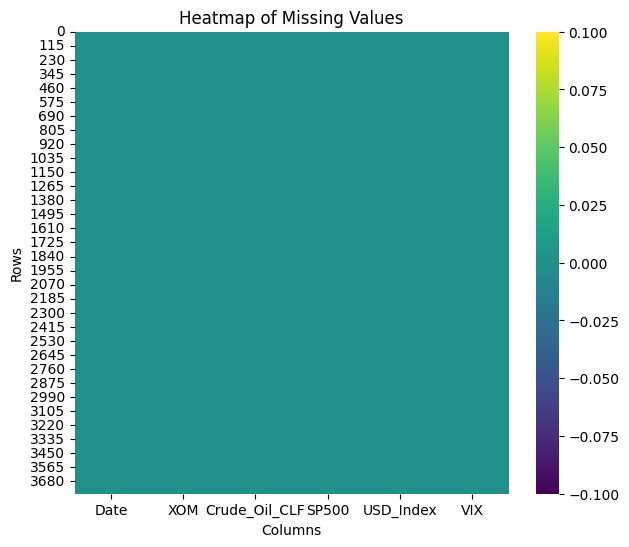

In [101]:
missing_values = df.isna()
missing_values_numeric = missing_values.astype(int)
plt.figure(figsize=(7, 6))
sns.heatmap(missing_values_numeric, cmap='viridis', cbar=True)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [103]:
# Check for duplicates in your DataFrame
duplicates = df[df.duplicated()]
print("Duplicates in df_oil:\n", duplicates)

Duplicates in df_oil:
 Empty DataFrame
Columns: [Date, XOM, Crude_Oil_CLF, SP500, USD_Index, VIX]
Index: []


In [105]:
df.value_counts()

Date        XOM         Crude_Oil_CLF  SP500        USD_Index   VIX      
2010-04-01  37.955788   84.870003      1178.099976  80.779999   17.469999    1
2020-04-16  30.601690   19.870001      2799.550049  100.029999  40.110001    1
2020-03-30  29.311958   20.090000      2626.649902  99.180000   57.080002    1
2020-03-31  29.679337   20.480000      2584.590088  99.050003   53.540001    1
2020-04-01  29.335407   20.309999      2470.500000  99.669998   57.060001    1
                                                                            ..
2015-04-09  54.175800   50.790001      2091.179932  99.160004   13.090000    1
2015-04-10  54.758213   51.639999      2102.060059  99.389999   12.580000    1
2015-04-13  54.617397   51.910000      2092.429932  99.489998   13.940000    1
2015-04-14  55.442986   53.290001      2095.840088  98.760002   13.670000    1
2025-04-11  102.198730  61.500000      5363.359863  99.779999   37.560001    1
Name: count, Length: 3780, dtype: int64

In [107]:
# Total memory usage of the entire DataFrame
total_memory = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Total memory usage: {total_memory:.2f} MB")

Total memory usage: 0.17 MB


In [109]:
df.index

RangeIndex(start=0, stop=3780, step=1)

In [119]:
'''
Date Column should be Index column and changed to DateTime format
'''

'\nDate Column should be Index column and changed to DateTime format\n'

In [115]:
df['Date'] = pd.to_datetime(df.Date)

In [121]:
df.set_index('Date', inplace = True)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3780 entries, 2010-04-01 to 2025-04-11
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   XOM            3780 non-null   float64
 1   Crude_Oil_CLF  3780 non-null   float64
 2   SP500          3780 non-null   float64
 3   USD_Index      3780 non-null   float64
 4   VIX            3780 non-null   float64
dtypes: float64(5)
memory usage: 177.2 KB


In [125]:
df.head()

,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
Date,,,,,
2010-04-01,37.955788,84.870003,1178.099976,80.779999,17.469999
2010-04-05,38.281406,86.620003,1187.439941,81.089996,17.020000
2010-04-06,38.118599,86.839996,1189.439941,81.389999,16.230000
2010-04-07,37.804211,85.879997,1182.449951,81.440002,16.620001
2010-04-08,38.096127,85.389999,1186.439941,81.529999,16.480000


In [127]:
df.index

DatetimeIndex(['2010-04-01', '2010-04-05', '2010-04-06', '2010-04-07',
               '2010-04-08', '2010-04-09', '2010-04-12', '2010-04-13',
               '2010-04-14', '2010-04-15',
               ...
               '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03',
               '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-09',
               '2025-04-10', '2025-04-11'],
              dtype='datetime64[ns]', name='Date', length=3780, freq=None)

In [131]:
print(df.index.freq)

None


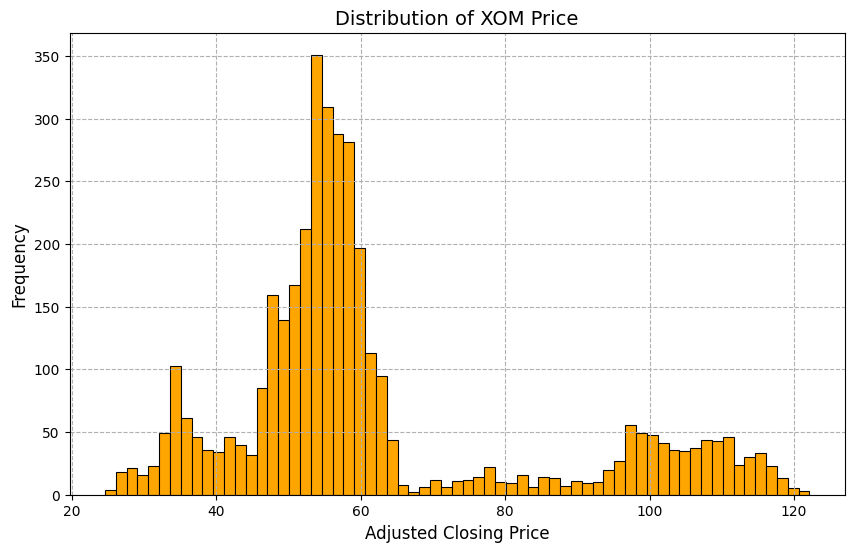

In [143]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df.XOM, alpha=1, color='orange', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Distribution of XOM Price', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

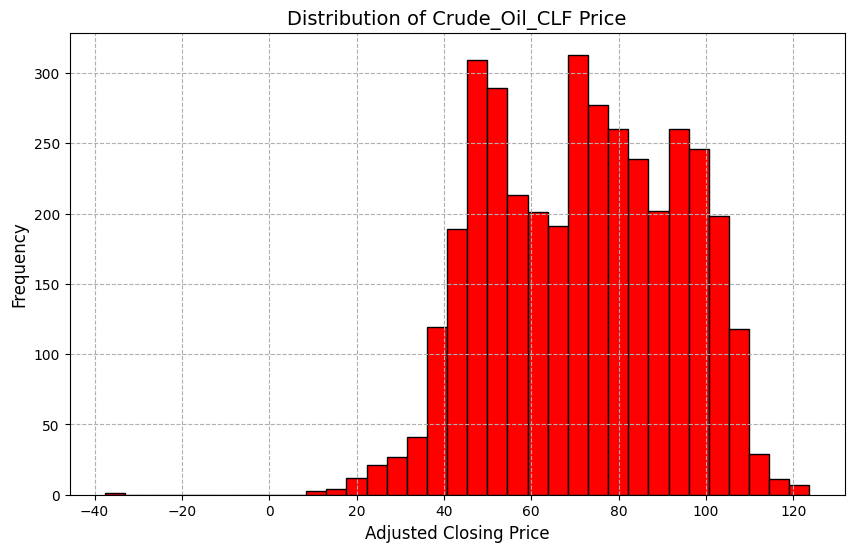

In [167]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df.Crude_Oil_CLF, alpha=1, color='red', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Distribution of Crude_Oil_CLF Price', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

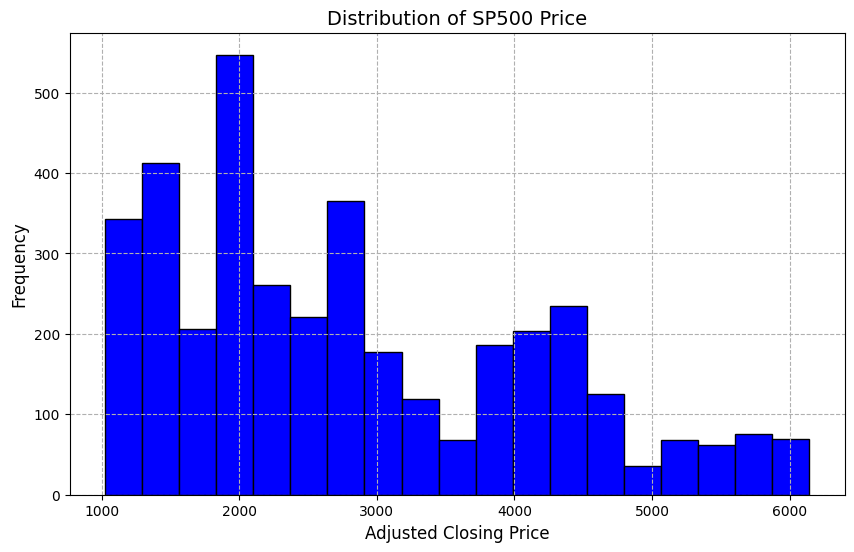

In [169]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df.SP500, alpha=1, color='blue', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Distribution of SP500 Price', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

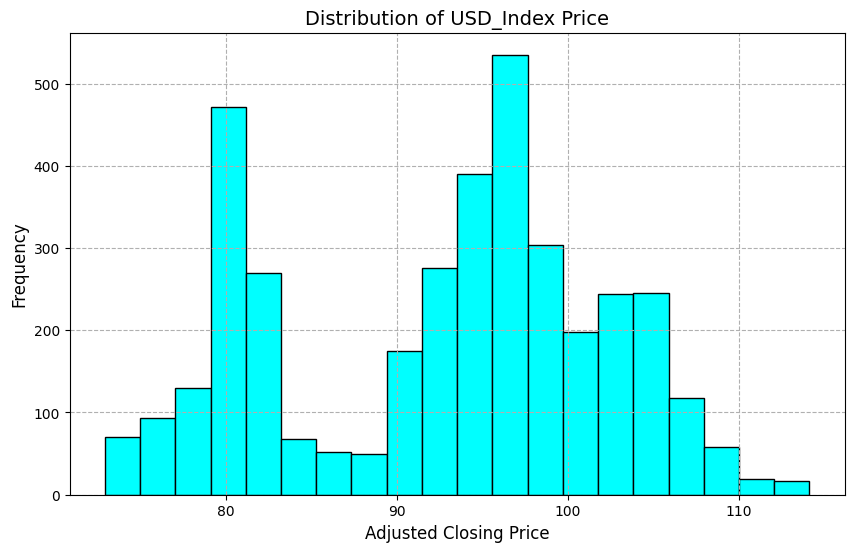

In [171]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df.USD_Index, alpha=1, color='cyan', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Distribution of USD_Index Price', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

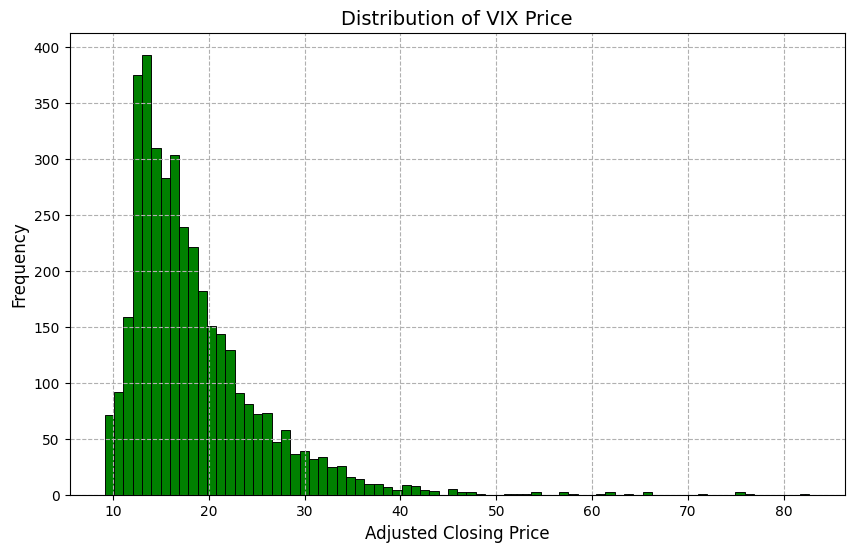

In [173]:
plt.figure(figsize=(10, 6)) 
sns.histplot(df.VIX, alpha=1, color='green', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Distribution of VIX Price', fontsize=14)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [147]:
df.columns

Index(['XOM', 'Crude_Oil_CLF', 'SP500', 'USD_Index', 'VIX'], dtype='object')

In [175]:
'''
it is problematic to apply transformations but still to check it out, i will do it.
'''

'\nit is problematic to apply transformations but still to check it out, i will do it.\n'

In [181]:
df_log = df.copy()
df_log.iloc[:, :] = df_log.iloc[:, :].apply(lambda x: np.log(x))

C:\Users\khali\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [185]:
df_log.head()

,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
Date,,,,,
2010-04-01,3.636422,4.441121,7.071658,4.391729,2.860485
2010-04-05,3.644964,4.461531,7.079555,4.395560,2.834389
2010-04-06,3.640702,4.464067,7.081238,4.399252,2.786861
2010-04-07,3.632420,4.452951,7.075344,4.399867,2.810607
2010-04-08,3.640113,4.447229,7.078712,4.400971,2.802147


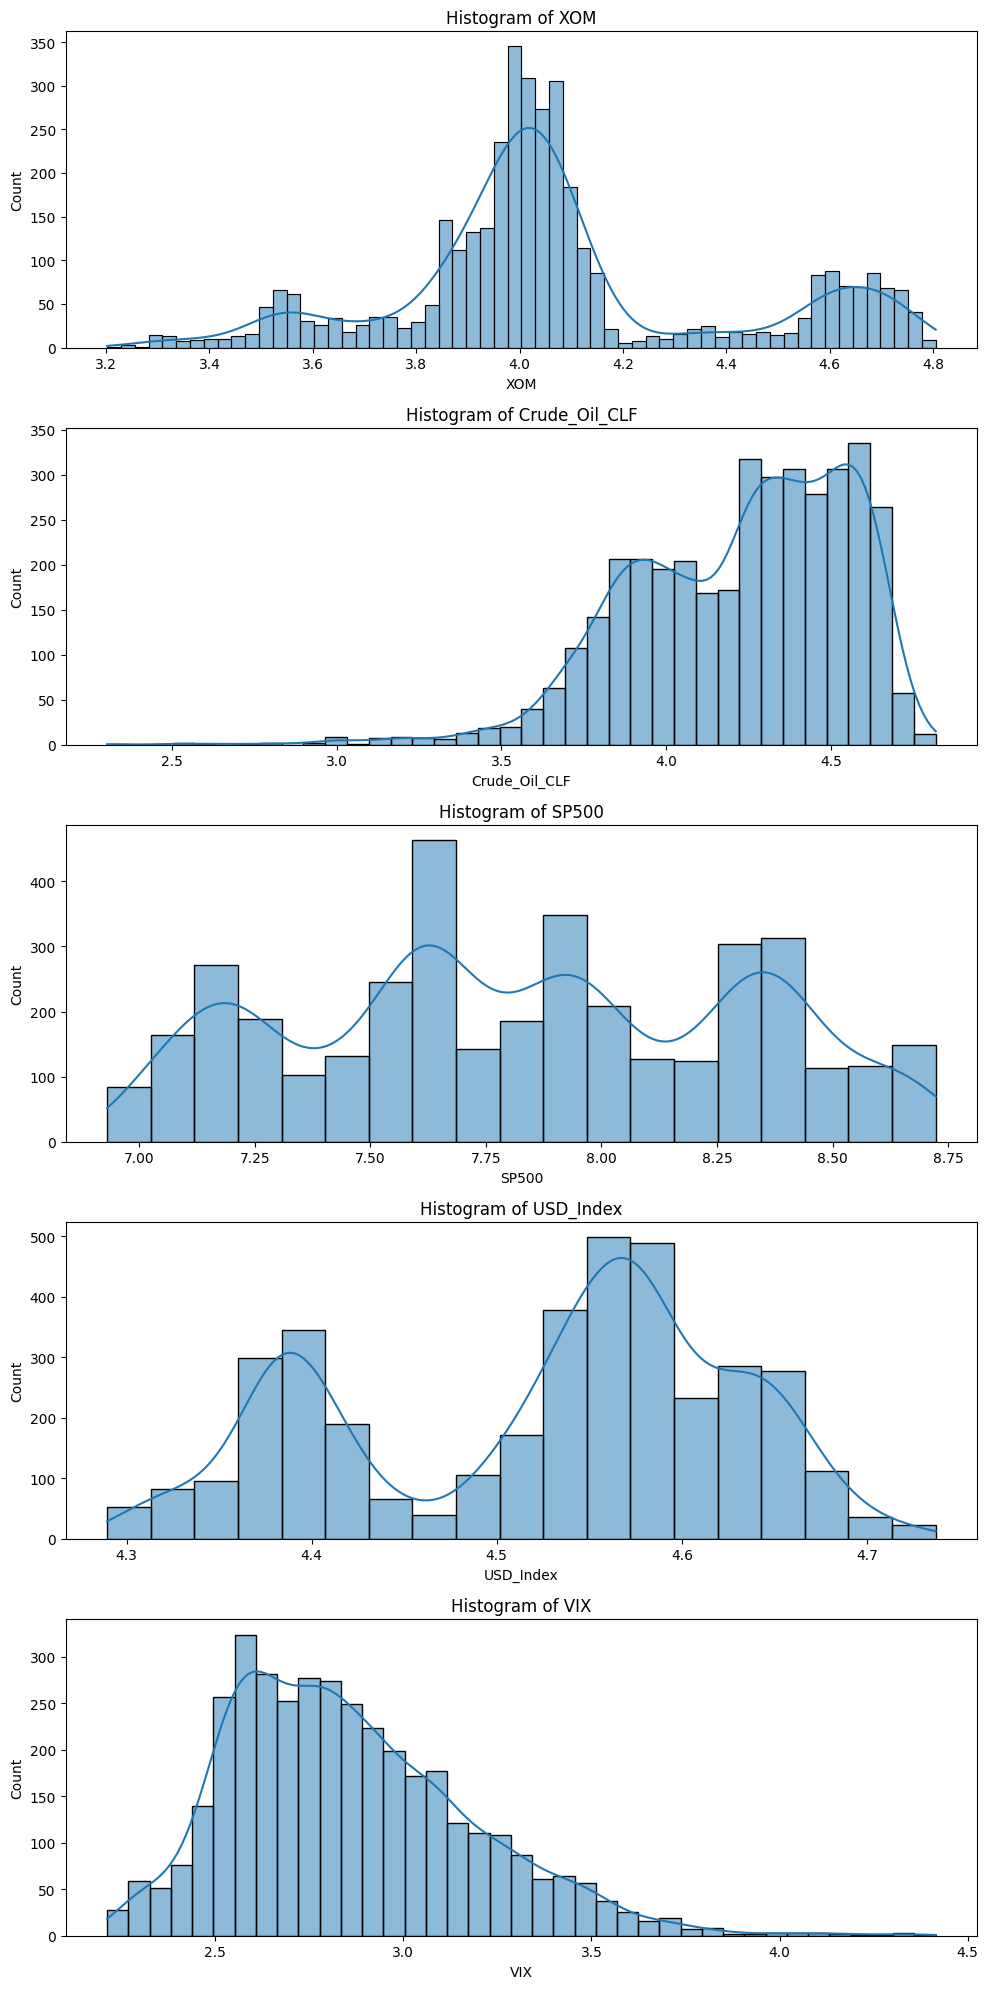

In [209]:
cols = df_log.columns
n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))
for i, col in enumerate(cols):
    sns.histplot(df_log[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

<Axes: >

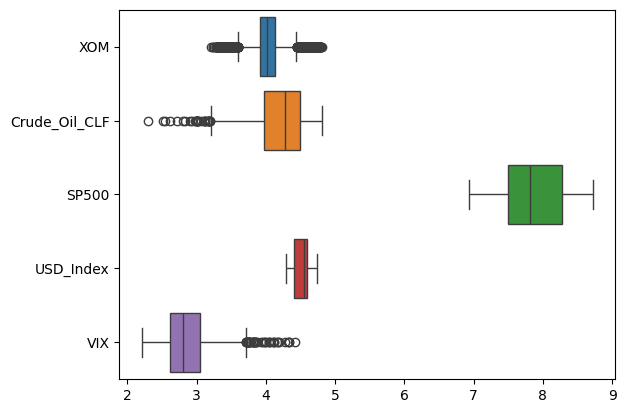

In [217]:
sns.boxplot(df_log, orient='h')

In [219]:
''' 
It would also work if we try to see their correlation using Pearson
'''

' \nIt would also work if we try to see their correlation using Pearson\n'

In [221]:
df_correlations = df.corr(method='pearson')

In [223]:
df_correlations

,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
XOM,1.000000,0.218946,0.726852,0.623473,-0.212037
Crude_Oil_CLF,0.218946,1.000000,-0.118247,-0.465631,-0.080193
SP500,0.726852,-0.118247,1.000000,0.766853,0.006442
USD_Index,0.623473,-0.465631,0.766853,1.000000,0.009932
VIX,-0.212037,-0.080193,0.006442,0.009932,1.000000


<Axes: >

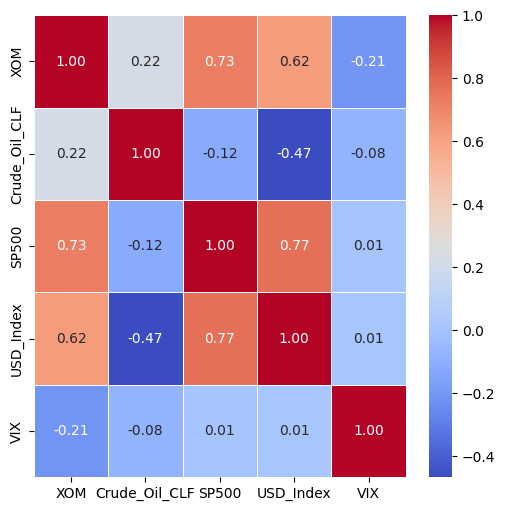

In [227]:
plt.figure(figsize=(6, 6))
sns.heatmap(df_correlations,
            annot = True, 
            cmap = 'coolwarm', 
            fmt = '.2f',
            linewidths = 0.5)

In [229]:
mask = np.triu(np.ones_like(df_correlations, dtype = bool))

In [231]:
correlations_with_xom = df_correlations.XOM.sort_values(ascending=False)
ordered_columns = correlations_with_xom.index
df_correlations = df_correlations[ordered_columns].loc[ordered_columns]

<Axes: >

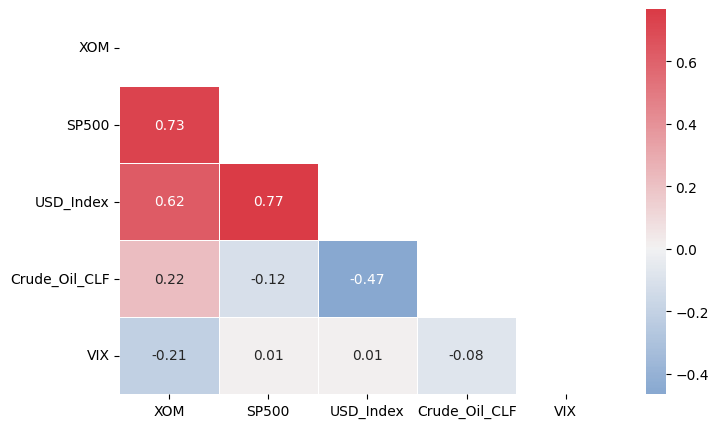

In [243]:
my_cmap = sns.diverging_palette(250, 10, as_cmap = True)
plt.figure(figsize=(8, 5))
sns.heatmap(df_correlations,
           annot = True,
           cmap = my_cmap,
           mask = mask,
           fmt = '.2f',
           linewidths = 0.5,
           # this argument ensures that the color map is centered at 0, 
           # meaning 0 will be displayed in white
           center = 0)

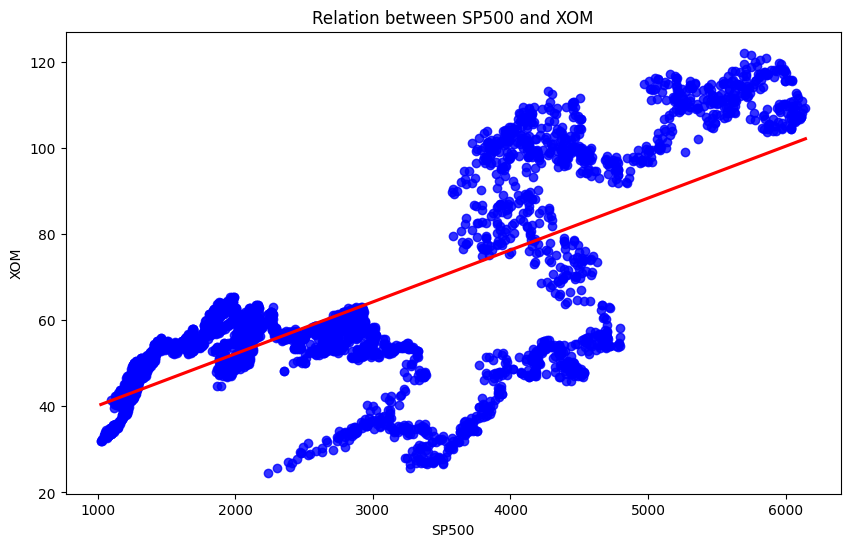

In [293]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'SP500', 
            y = 'XOM',
            data = df,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between SP500 and XOM')
plt.xlabel('SP500')
plt.ylabel('XOM')
plt.show()

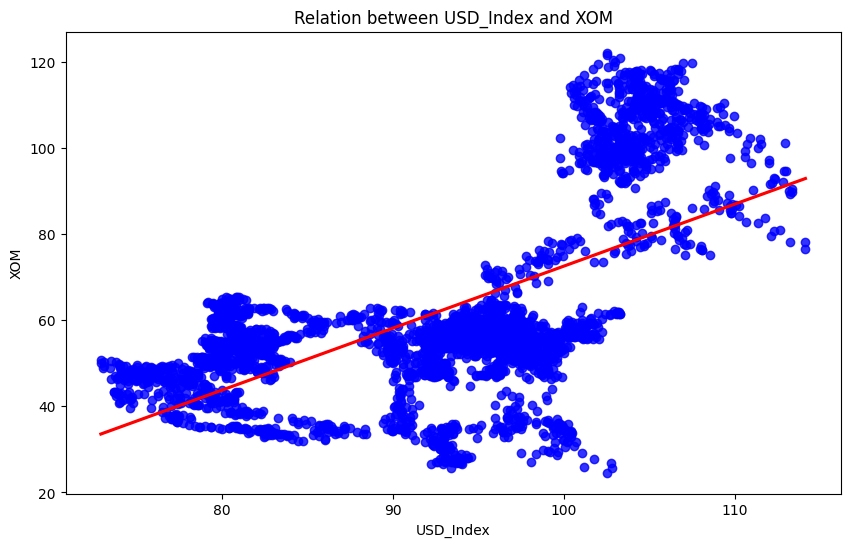

In [255]:
plt.figure(figsize=(10, 6))
sns.regplot(x = 'USD_Index', 
            y = 'XOM',
            data = df,
            scatter_kws = {'color': 'blue'}, # color for the scatter points
            line_kws = {'color': 'red'},     # color for the regression line
            ci = None                        # No confidence interval for the line
           )
plt.title('Relation between USD_Index and XOM')
plt.xlabel('USD_Index')
plt.ylabel('XOM')
plt.show()

## Business Day Frequency

In [274]:
''' 
Data is in Business Day Frequency
'''

' \nData is in Business Day Frequency\n'

In [266]:
df = df.resample('B').ffill()

In [268]:
df.index.freq

<BusinessDay>

In [276]:
df.isna().sum()

XOM              0
Crude_Oil_CLF    0
SP500            0
USD_Index        0
VIX              0
dtype: int64

## Train - Test Split

In [279]:
df_train = df[df.index < '2023-01-01']
df_test = df[df.index >= '2023-01-01']

In [281]:
df_train.tail()

,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
Date,,,,,
2022-12-26,99.805183,79.559998,3844.820068,104.309998,20.870001
2022-12-27,101.191872,79.529999,3829.250000,104.180000,21.650000
2022-12-28,99.529663,78.959999,3783.219971,104.459999,22.139999
2022-12-29,100.282715,78.400002,3849.280029,103.839996,21.440001
2022-12-30,101.292900,80.260002,3839.500000,103.519997,21.670000


In [283]:
df_test.head()

,XOM,Crude_Oil_CLF,SP500,USD_Index,VIX
Date,,,,,
2023-01-02,101.292900,80.260002,3839.500000,103.519997,21.670000
2023-01-03,97.812386,76.930000,3824.139893,104.519997,22.900000
2023-01-04,98.097046,72.839996,3852.969971,104.250000,22.010000
2023-01-05,100.291908,73.669998,3808.100098,105.040001,22.459999
2023-01-06,101.504112,73.769997,3895.080078,103.879997,21.129999


In [285]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3327 entries, 2010-04-01 to 2022-12-30
Freq: B
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   XOM            3327 non-null   float64
 1   Crude_Oil_CLF  3327 non-null   float64
 2   SP500          3327 non-null   float64
 3   USD_Index      3327 non-null   float64
 4   VIX            3327 non-null   float64
dtypes: float64(5)
memory usage: 156.0 KB


In [287]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2023-01-02 to 2025-04-11
Freq: B
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   XOM            595 non-null    float64
 1   Crude_Oil_CLF  595 non-null    float64
 2   SP500          595 non-null    float64
 3   USD_Index      595 non-null    float64
 4   VIX            595 non-null    float64
dtypes: float64(5)
memory usage: 27.9 KB


## Outlier Detection

In [326]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])  # Calculate the 25th and 75th percentiles
    IQR = q3 - q1  # Interquartile range
    lower_fence = q1 - (1.5 * IQR)  # Lower bound for outliers
    upper_fence = q3 + (1.5 * IQR)  # Upper bound for outliers
    return data[(data > upper_fence) | (data < lower_fence)] 

In [328]:
outliers_xom= iqr_outliers(df.XOM)
outliers_xom

Date
2010-06-29     32.380627
2010-06-30     32.256283
2010-07-01     31.996298
2010-07-02     31.973680
2010-07-05     31.973680
                 ...    
2025-04-07    102.000557
2025-04-08     99.850357
2025-04-09    104.834457
2025-04-10     99.018028
2025-04-11    102.198730
Name: XOM, Length: 829, dtype: float64

In [306]:
def zscore(df, column_name, degree=3):
    data = df.copy()
    data['zscore'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    return outliers[column_name], data

In [316]:
threshold = 2
outliers, transformed_xom = zscore(df, 'XOM', threshold)

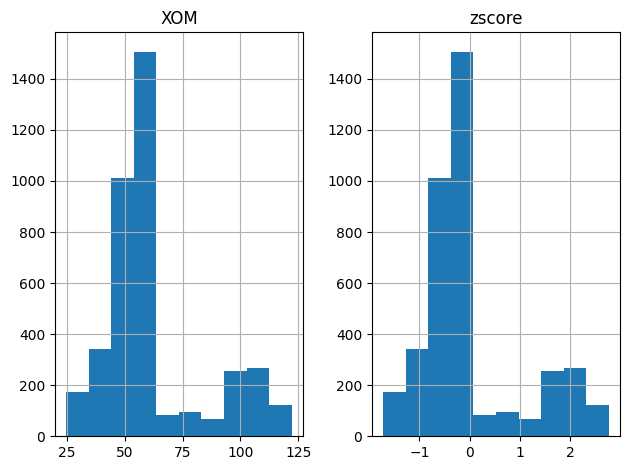

In [318]:
transformed_xom[['XOM', 'zscore']].hist(); plt.tight_layout()

In [320]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(10, 6))
    plt.plot(data, 'k^')
    plt.plot([0, n], [d, d], 'r--')
    plt.plot([0, n], [-d, -d], 'r--')

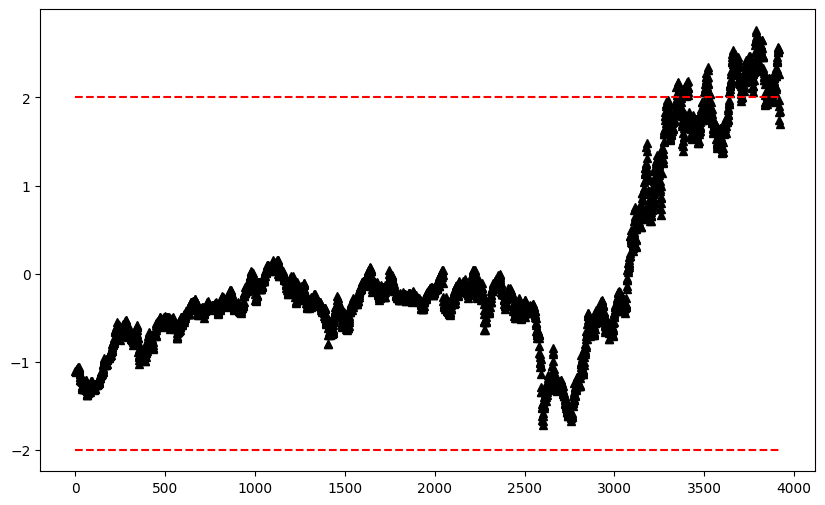

In [322]:
data = transformed_xom['zscore'].values
plot_zscore(data, d=2)

In [330]:
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print('Reject null hypothesis. Data is not normally distributed')
    else:
        print('Fail to reject null hypothesis. Data is normally distributed')

In [340]:
test_normal(df_train.XOM)

Reject null hypothesis. Data is not normally distributed


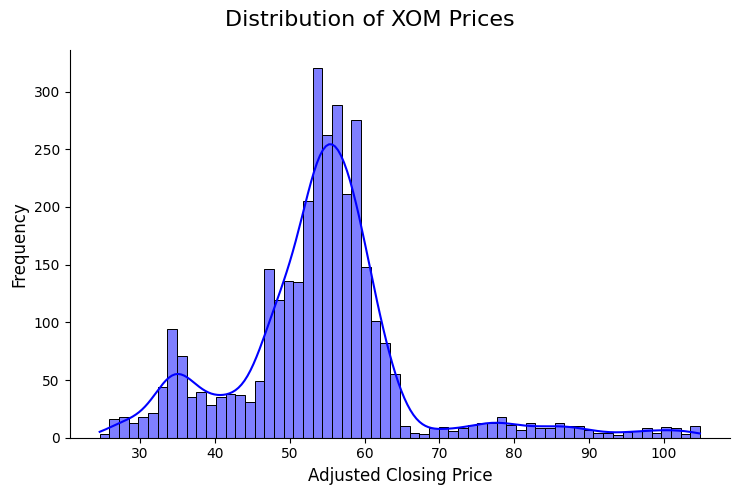

In [342]:
sns.displot(df_train['XOM'], kde=True, color='blue', height=5, aspect=1.5)
plt.suptitle('Distribution of XOM Prices', fontsize=16)
plt.xlabel('Adjusted Closing Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [344]:
import statsmodels.api as sm

<Figure size 500x500 with 0 Axes>

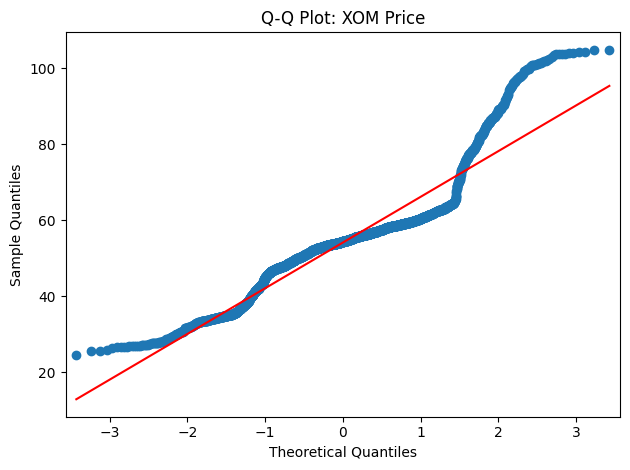

In [352]:
plt.figure(figsize=(5, 5))
sm.qqplot(df_train['XOM'], line='s')
plt.title('Q-Q Plot: XOM Price')
plt.tight_layout()
plt.show()

## Train Data Plots

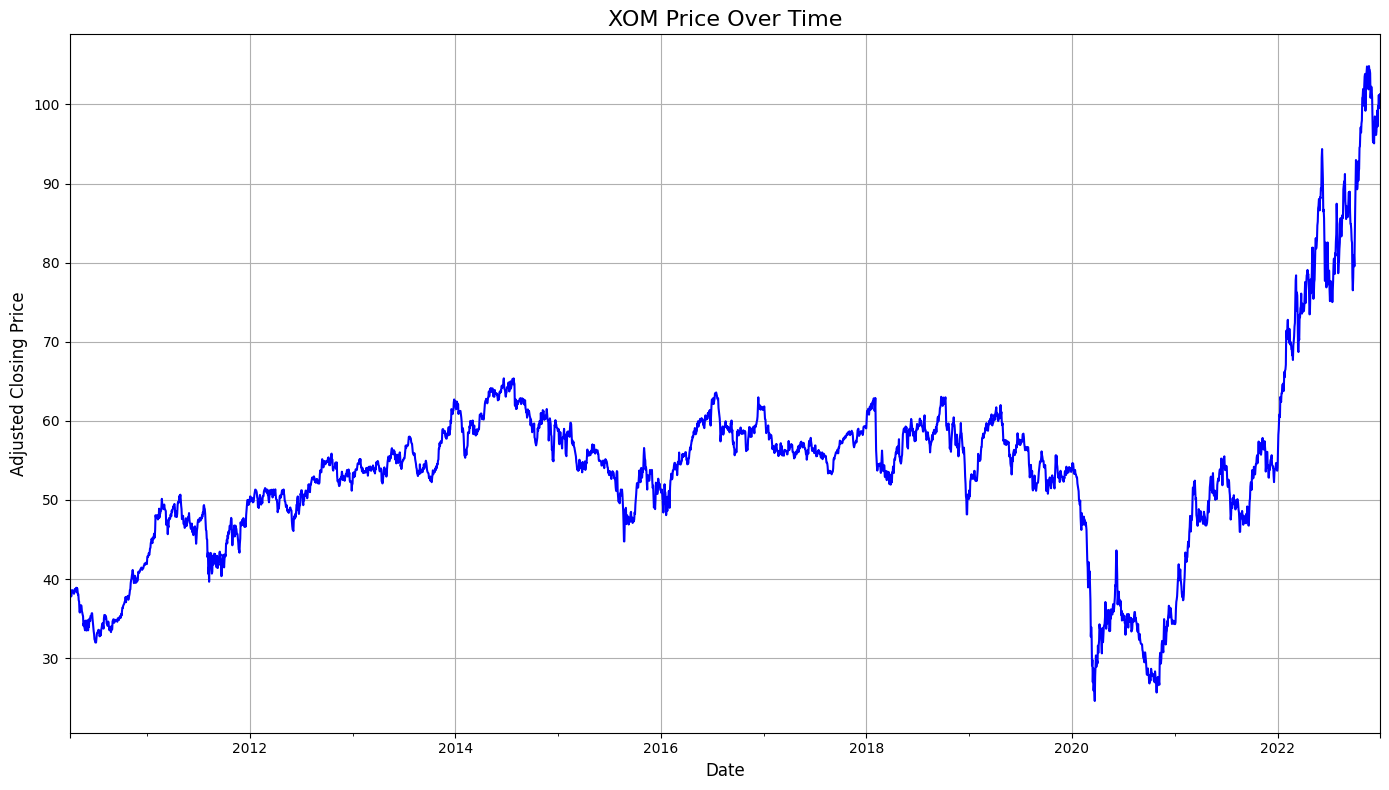

In [422]:
plt.figure(figsize=(14, 8))
df_train['XOM'].plot(color='blue', linewidth=1.5, grid=True)
plt.title('XOM Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

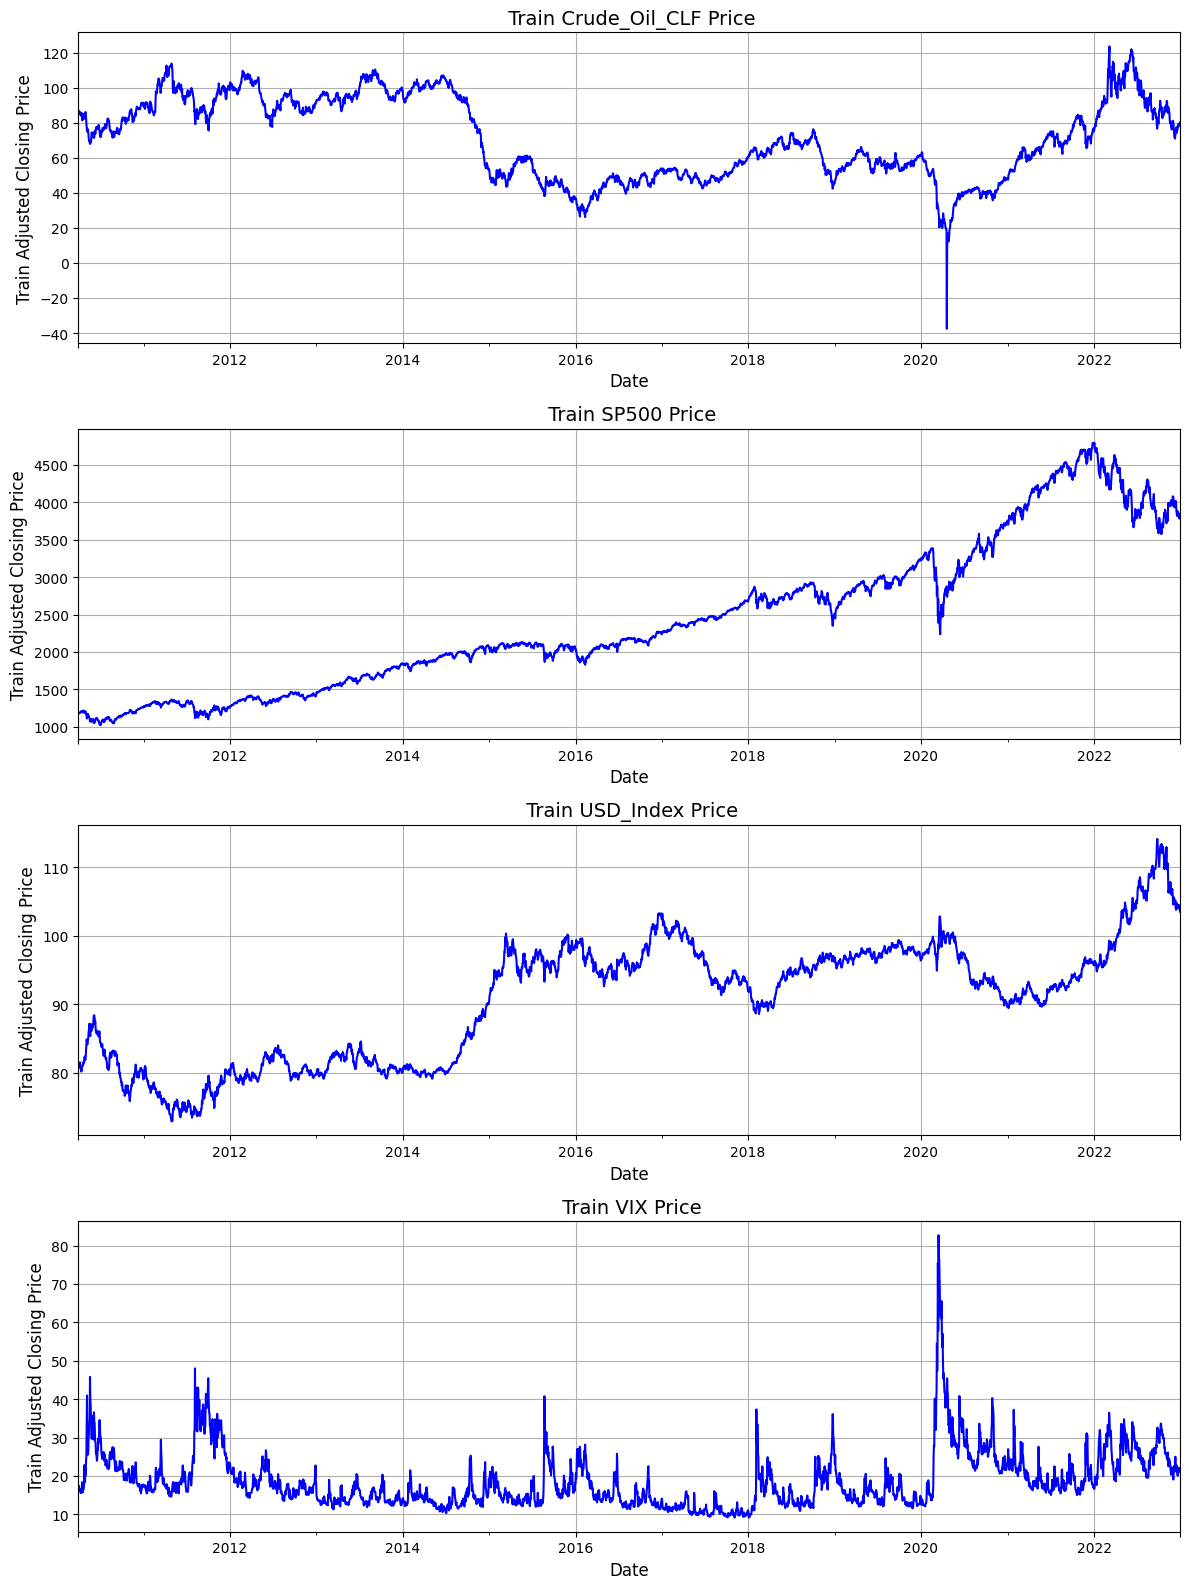

In [420]:
cols = df_train.columns[1:]
n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))  # 1 column, n rows
for i, col in enumerate(cols):
    df_train[col].plot(ax=axes[i], color='blue', linewidth=1.5, grid=True)
    axes[i].set_title(f' Train {col} Price', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Train Adjusted Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

## Test Data Plots

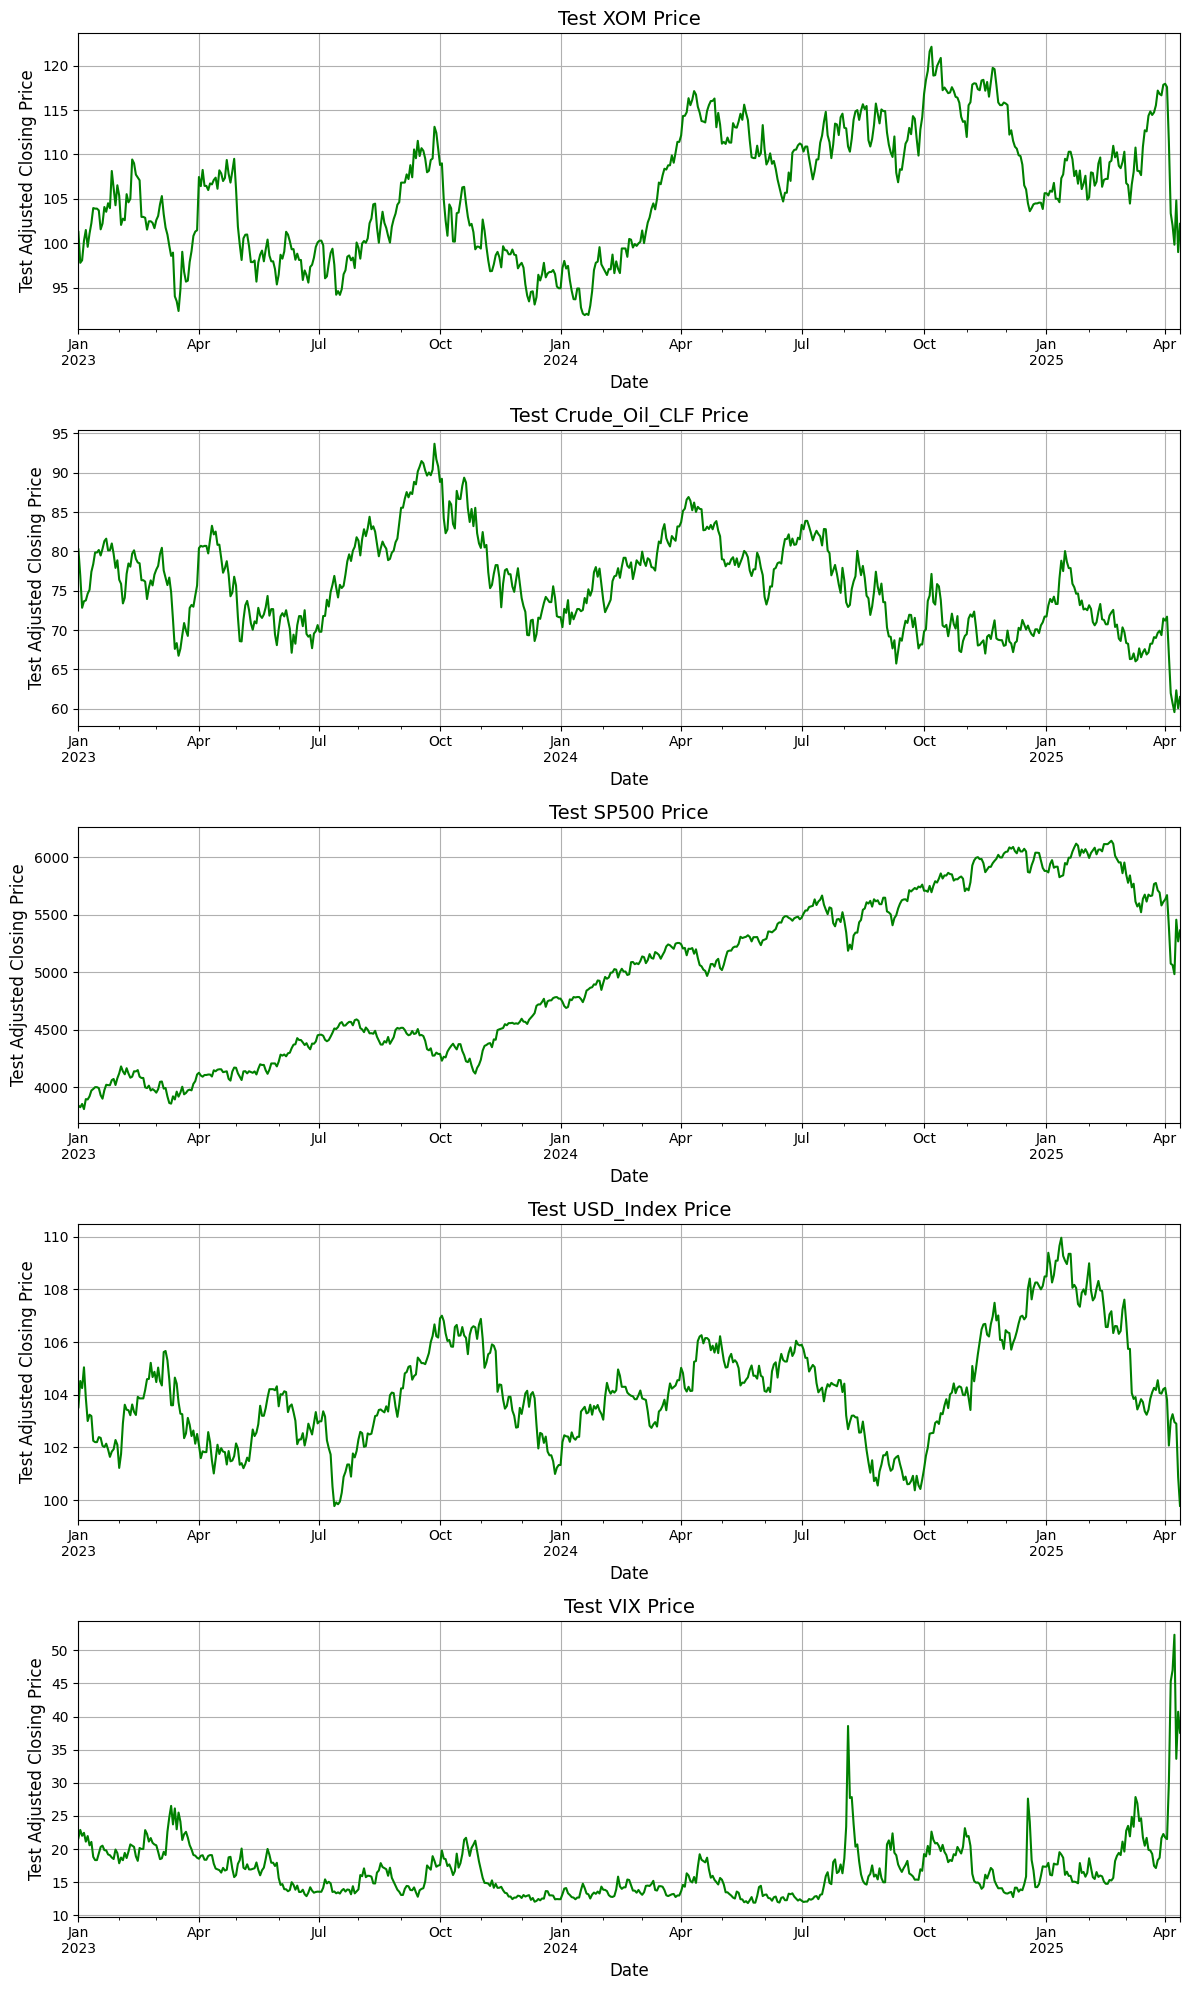

In [418]:
cols = df_test.columns[:]
n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))  # 1 column, n rows
for i, col in enumerate(cols):
    df_test[col].plot(ax=axes[i], color='green', linewidth=1.5, grid=True)
    axes[i].set_title(f'Test {col} Price', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Test Adjusted Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

In [434]:
'''
from statsmodels.tsa.stattools import adfuller

# 1. Random walk (no drift, no trend)
adfuller(series, regression='nc')  # 'nc' = no constant

# 2. Random walk with drift (intercept)
adfuller(series, regression='c')   # 'c' = constant

# 3. Random walk with drift + trend
adfuller(series, regression='ct')  # 'ct' = constant + trend


“c” : constant only (default).

“ct” : constant and trend.

“ctt” : constant, and linear and quadratic trend.

“n” : no constant, no trend.

'''

"\nfrom statsmodels.tsa.stattools import adfuller\n\n# 1. Random walk (no drift, no trend)\nadfuller(series, regression='nc')  # 'nc' = no constant\n\n# 2. Random walk with drift (intercept)\nadfuller(series, regression='c')   # 'c' = constant\n\n# 3. Random walk with drift + trend\nadfuller(series, regression='ct')  # 'ct' = constant + trend\n\n\n“c” : constant only (default).\n\n“ct” : constant and trend.\n\n“ctt” : constant, and linear and quadratic trend.\n\n“n” : no constant, no trend.\n\n"

In [426]:
from statsmodels.tsa.stattools import adfuller

## ADF test

In [440]:
adfuller(df_train.XOM, regression = 'n')

(1.4520720780480987,
 0.9634238118593262,
 26,
 3300,
 {'1%': -2.5664178482093662,
  '5%': -1.9410817020696498,
  '10%': -1.616739763665192},
 8083.182876839923)

In [453]:
adfuller(df_train.XOM, regression = 'ct')

(-0.4189376698263649,
 0.9862948541344094,
 26,
 3300,
 {'1%': -3.9615159778377436,
  '5%': -3.4118212552570886,
  '10%': -3.1278338761966777},
 8085.532117403099)

In [459]:
adfuller(df_train.XOM, regression = 'ctt')

(-0.2219871848979949,
 0.9984011360991495,
 26,
 3300,
 {'1%': -4.374644874217297,
  '5%': -3.834180756275816,
  '10%': -3.554369457507833},
 8080.55842190708)

## First Order Differencing for ADF Test

In [570]:
train_xom_diff = df_train.diff().dropna()

In [512]:
# no constant and no trend

In [572]:
adfuller(train_xom_diff.XOM, regression = 'n')

(-11.87939248742981,
 1.2226806733997e-21,
 25,
 3300,
 {'1%': -2.5664178482093662,
  '5%': -1.9410817020696498,
  '10%': -1.616739763665192},
 8081.830299002901)

In [468]:
# constant and trend

In [505]:
adfuller(train_xom_diff.XOM, regression = 'ct')

(-12.02930229994978,
 3.445710986471244e-19,
 25,
 3300,
 {'1%': -3.9615159778377436,
  '5%': -3.4118212552570886,
  '10%': -3.1278338761966777},
 8082.259502671676)

In [470]:
# constant, and linear and quadratic trend

In [507]:
adfuller(train_xom_diff.XOM, regression = 'ctt')

(-12.335921064420905,
 4.335901827084542e-20,
 25,
 3300,
 {'1%': -4.374644874217297,
  '5%': -3.834180756275816,
  '10%': -3.554369457507833},
 8077.154020786025)

In [474]:
'''
From the results it is obvious that First Order Differencing is enough to make
our data stationary.
'''

'\nFrom the results it is obvious that First Order Differencing is enough to make\nour data stationary.\n'

In [520]:
import warnings; warnings.filterwarnings('ignore')

## KPSS Test

In [487]:
'''
Regression {“c”, “ct”}
The null hypothesis for the KPSS test.

“c” : The data is stationary around a constant (default).

“ct” : The data is stationary around a trend.

'''

'\nRegression {“c”, “ct”}\nThe null hypothesis for the KPSS test.\n\n“c” : The data is stationary around a constant (default).\n\n“ct” : The data is stationary around a trend.\n\n'

In [522]:
kpss(df_train.XOM, regression='c')

(1.209969159720067,
 0.01,
 37,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [489]:
# above we have a p-value of 0.01 which rejects Null: Data is Stationary

In [524]:
kpss(df_train.XOM, regression='ct')

(0.509714963305645,
 0.01,
 37,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [493]:
# above we have a p-value of 0.01 which rejects Null: Data is Stationary

In [495]:
# for kpps we need our p > 0.05 to fail to reject H0: Data is stationary

## First Order Differencing for KPSS Test

In [503]:
# train_xom_diff
# this is diff() df

In [526]:
kpss(train_xom_diff.XOM, regression='c')

(0.2597253392491045,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [516]:
# here p-value is > 0.05 which fails to reject the H0: data is stationary

In [546]:
kpss(train_xom_diff.XOM, regression='ct')

(0.17291671178060217,
 0.027569406849498188,
 11,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

## Phillips Perron Test

In [533]:
from arch.unitroot import PhillipsPerron

In [537]:
print(PhillipsPerron(df_train.XOM))

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.200
P-value                         0.938
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## First Order Differencing for PP Test

In [542]:
print(PhillipsPerron(train_xom_diff.XOM))

     Phillips-Perron Test (Z-tau)    
Test Statistic                -56.685
P-value                         0.000
Lags                               29
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Result from Three Stationarity Tests

---
From all 3 tests it is obvious that First Order Differencing is enough to make our Data Stationary.

---

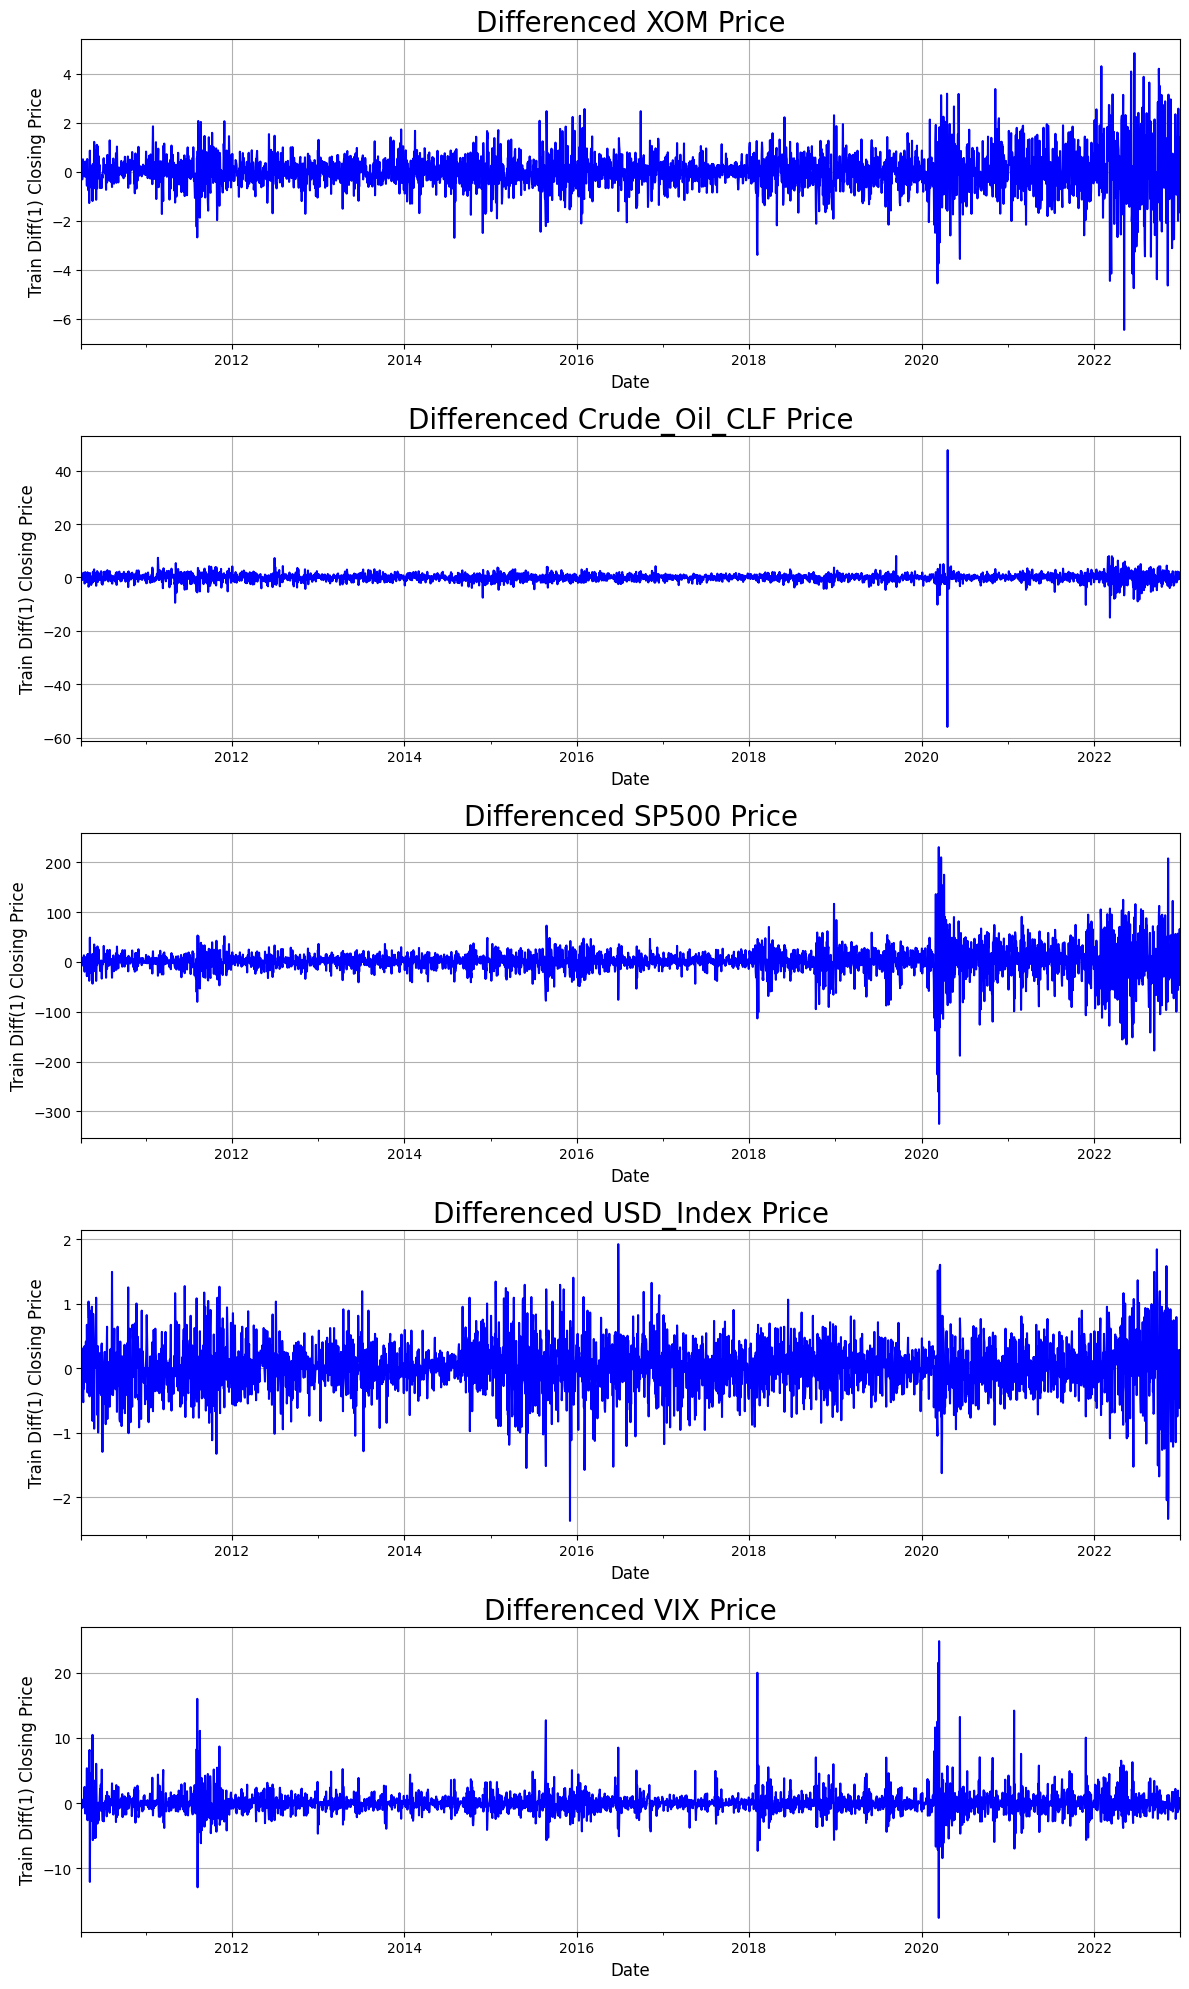

In [599]:
cols = df_train.columns[:]
n = len(cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))  # 1 column, n rows
for i, col in enumerate(cols):
    train_xom_diff[col].plot(ax=axes[i], color='blue', linewidth=1.5, grid=True)
    axes[i].set_title(f'Differenced {col} Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Train Diff(1) Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

In [574]:
diff_xom = df_train.XOM.diff().dropna()

In [576]:
def print_results(output, test='adf'):
    if test == 'pp':
        pval = output.pvalue
        test_score = output.stat
        lags = output.lags
        critical = output.critical_values
        decision = 'Stationary' if pval < 0.05 else 'Non-Stationary'
    else:
        pval = output[1]
        test_score = output[0]
        lags = output[2]
        decision = 'Non-Stationary'
        if test == 'adf':
            critical = output[4]
            if pval < 0.05:
                decision = 'Stationary'
        elif test == 'kpss':
            critical = output[3]
            if pval >= 0.05:
                decision = 'Stationary'

    output_dict = {
        'Test Statistic': test_score, 
        'p-value': pval,
        'Number of lags': lags, 
        'Decision': decision
    }

    for key, value in critical.items():
        output_dict[f'Critical Value ({key})'] = value

    return pd.Series(output_dict, name=test)

In [578]:
series = diff_xom

In [580]:
adf_output = adfuller(series)
kpss_output = kpss(series, regression='c')
pp_output = PhillipsPerron(series)

In [582]:
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss'),
    print_results(pp_output, 'pp')
], axis=1)

,adf,kpss,pp
Test Statistic,-11.973532,0.259725,-56.685317
p-value,0.0,0.1,0.0
Number of lags,25,11,29
Decision,Stationary,Stationary,Stationary
Critical Value (1%),-3.432333,0.739,-3.432318
Critical Value (5%),-2.862416,0.463,-2.86241
Critical Value (10%),-2.567236,0.347,-2.567233
Critical Value (2.5%),NaN,0.574,NaN


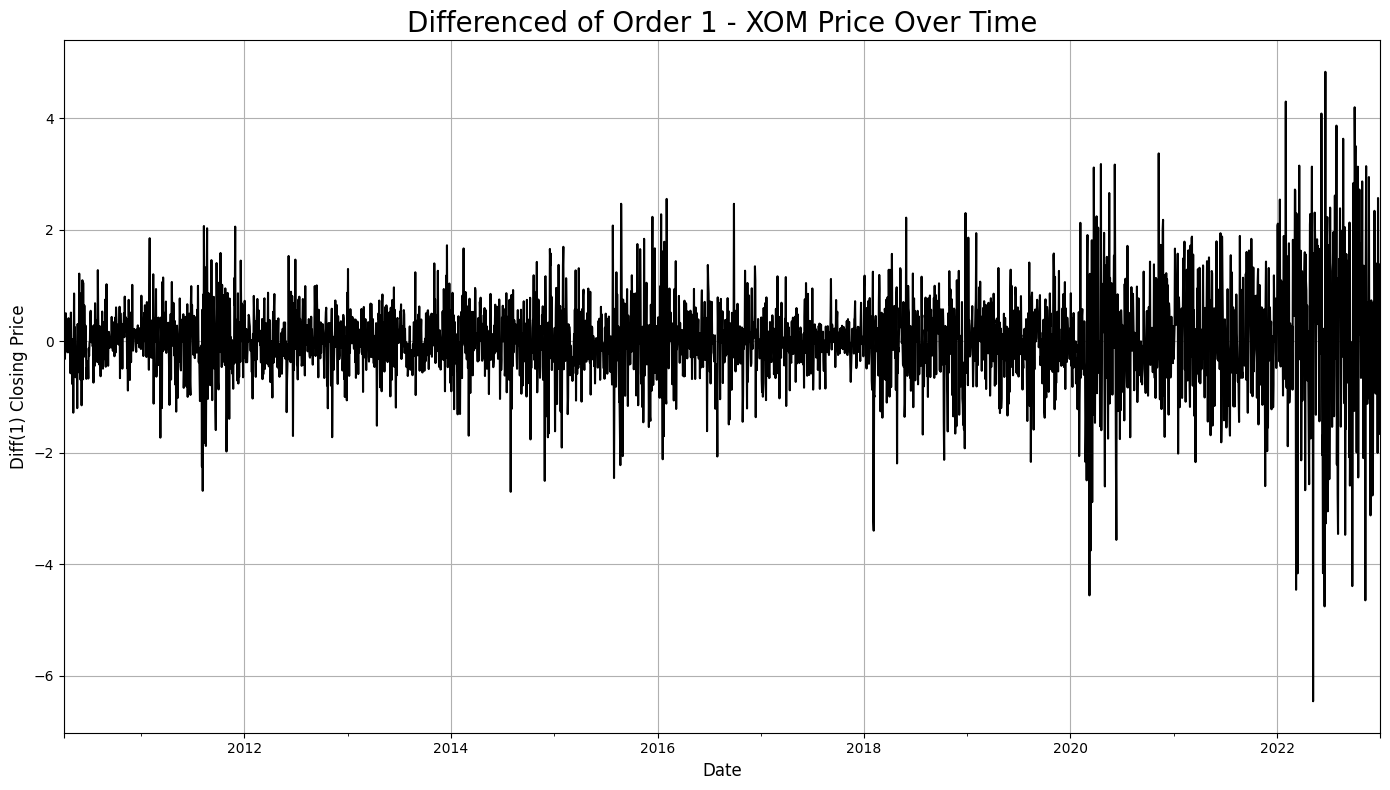

In [591]:
plt.figure(figsize=(14, 8))
diff_xom.plot(color='black', linewidth=1.5, grid=True)
plt.title('Differenced of Order 1 - XOM Price Over Time', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Diff(1) Closing Price', fontsize=12)
plt.tight_layout()
plt.show()

---

diff_xom for series object \
train_xom_diff for all differenced variables

---

In [621]:
import statsmodels.stats.diagnostic as smd

In [643]:
# def adf_test(series, max_aug=10, version='n'):
    
#     results = []

#     y = series.diff()
#     X = pd.DataFrame({'y_lag': series.shift()})

#     if version == 'c' or version == 't': # constant to be added optionally 
#         X = sm.add_constant(X)
#     if version == 't': # (deterministic) trend component to be added optionally
#         X['trend'] = range(len(X))

#     for i in range(0, max_aug): # iterating through different numbers of augmentations
        
#         for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
#             X['aug_'+str(aug)] = y.shift(aug)

#         model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

#         ts = model.tvalues['y_lag'] # test statistic
#         nobs = model.nobs # number of observations

#         if version == 'n': # critical values for basic version of ADF
#             if nobs > 500:
#                 cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
#             else:
#                 cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
#         if version == 'c': # critical values for version with constant
#             if nobs > 500:
#                 cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
#             else:
#                 cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
#         if version == 't': # critical values for version with constant and (deterministic) trend component
#             if nobs > 500:
#                 cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
#             else:
#                 cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

#         bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
#         bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
#         bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

#         results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

#     results_df = pd.DataFrame(results)
#     results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    
#     return results_df

In [645]:
def adf_test(series, max_aug=10, version='n'):
    results = []

    for i in range(0, max_aug):
        y = series.diff()
        X = pd.DataFrame({'y_lag': series.shift()})

        if version == 'c' or version == 't':
            X = sm.add_constant(X)
        if version == 't':
            X['trend'] = range(len(X))

        for aug in range(1, i + 1):
            X[f'aug_{aug}'] = y.shift(aug)

        model = sm.OLS(y, X, missing='drop').fit()
        ts = model.tvalues['y_lag']
        nobs = model.nobs

        if version == 'n':
            cv1, cv5, cv10 = (-2.567, -1.941, -1.616) if nobs > 500 else (np.nan, np.nan, np.nan)
        elif version == 'c':
            cv1, cv5, cv10 = (-3.434, -2.863, -2.568) if nobs > 500 else (np.nan, np.nan, np.nan)
        elif version == 't':
            cv1, cv5, cv10 = (-3.963, -3.413, -3.128) if nobs > 500 else (np.nan, np.nan, np.nan)
        else:
            cv1 = cv5 = cv10 = np.nan

        # Add Breusch-Godfrey p-values
        bg_pvalue5 = round(smd.acorr_breusch_godfrey(model, nlags=5)[1], 4)
        bg_pvalue10 = round(smd.acorr_breusch_godfrey(model, nlags=10)[1], 4)
        bg_pvalue15 = round(smd.acorr_breusch_godfrey(model, nlags=15)[1], 4)

        # True ADF test p-value using built-in method
        adf_pvalue = round(adfuller(series.dropna(), maxlag=i, regression=version)[1], 4)

        results.append([
            i, ts, adf_pvalue, cv1, cv5, cv10,
            bg_pvalue5, bg_pvalue10, bg_pvalue15
        ])

    results_df = pd.DataFrame(results, columns=[
        'number of augmentations', 'ADF test statistic', 'ADF p-value',
        'ADF critical value (1%)', 'ADF critical value (5%)', 'ADF critical value (10%)',
        'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)'
    ])

    return results_df

In [609]:
df_train['diff_xom'] = diff_xom

### Augmentations

In [647]:
adf_test(df_train['XOM'], max_aug=10)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,1.246461,0.9453,-2.567,-1.941,-1.616,0.0053,0.0009,0.0016
1,1,1.211802,0.9453,-2.567,-1.941,-1.616,0.0071,0.0011,0.0020
2,2,1.230247,0.9453,-2.567,-1.941,-1.616,0.0086,0.0013,0.0023
3,3,1.346144,0.9548,-2.567,-1.941,-1.616,0.0149,0.0293,0.0386
4,4,1.268491,0.9475,-2.567,-1.941,-1.616,0.0487,0.0786,0.1527
5,5,1.241752,0.9475,-2.567,-1.941,-1.616,0.0238,0.0977,0.1633
6,6,1.333925,0.9537,-2.567,-1.941,-1.616,0.2123,0.3873,0.7059
7,7,1.318303,0.9537,-2.567,-1.941,-1.616,0.1728,0.3728,0.6460
8,8,1.355391,0.9537,-2.567,-1.941,-1.616,0.1128,0.1580,0.4535
9,9,1.302816,0.9537,-2.567,-1.941,-1.616,0.2031,0.2539,0.4560


In [656]:
'''

The test shows that I need 6 augmentations, and I can trust it
And p-value is 0.9537 which fails to reject the Null Hypothesis: Data is non-stationary.
Now, will check the first order differenced values

'''

'\n\nThe test shows that I need 6 augmentations, and I can trust it\nAnd p-value is 0.9537 which fails to reject the Null Hypothesis: Data is non-stationary.\nNow, will check the first order differenced values\n\n'

In [653]:
adfuller(df_train.diff_xom.dropna(), regression='ct', maxlag=6)

(-24.53699923306617,
 0.0,
 5,
 3320,
 {'1%': -3.961499420127026,
  '5%': -3.411813230663636,
  '10%': -3.1278291518853396},
 8124.497447080987)

In [658]:
adf_test(df_train['diff_xom'], max_aug=10)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.663180,0.0,-2.567,-1.941,-1.616,0.0002,0.0013,0.0023
1,1,-40.842327,0.0,-2.567,-1.941,-1.616,0.0097,0.0015,0.0025
2,2,-35.127565,0.0,-2.567,-1.941,-1.616,0.0157,0.0310,0.0401
3,3,-28.812417,0.0,-2.567,-1.941,-1.616,0.0529,0.0807,0.1602
4,4,-25.474400,0.0,-2.567,-1.941,-1.616,0.0257,0.1053,0.1716
5,5,-24.463608,0.0,-2.567,-1.941,-1.616,0.2230,0.4019,0.7159
6,6,-22.322968,0.0,-2.567,-1.941,-1.616,0.1775,0.3873,0.6567
7,7,-21.179101,0.0,-2.567,-1.941,-1.616,0.1197,0.1660,0.4801
8,8,-19.329730,0.0,-2.567,-1.941,-1.616,0.2158,0.2581,0.4671
9,9,-17.913668,0.0,-2.567,-1.941,-1.616,0.4062,0.2119,0.4890


In [660]:
'''

Test shows that I can trust to the 3rd line, where 3 augmentations needed.
And p-value is 0.0 which rejects the Null Hypothesis: data is non-stationary.
Conclusion is, first order of differencing is enough to make our data stationary.

'''

'\n\nTest shows that I can trust to the 3rd line, where 3 augmentations needed.\nAnd p-value is 0.0 which rejects the Null Hypothesis: data is non-stationary.\nConclusion is, first order of differencing is enough to make our data stationary.\n\n'

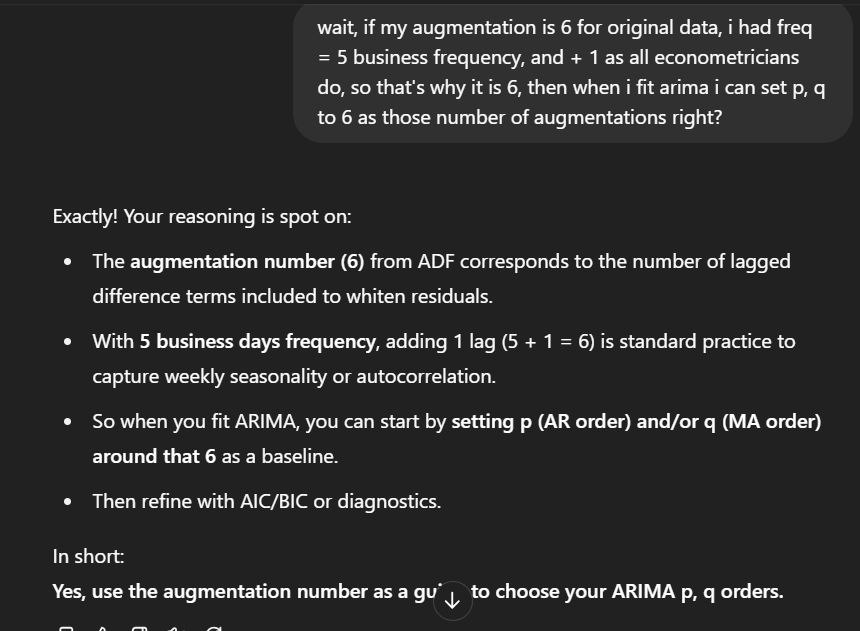

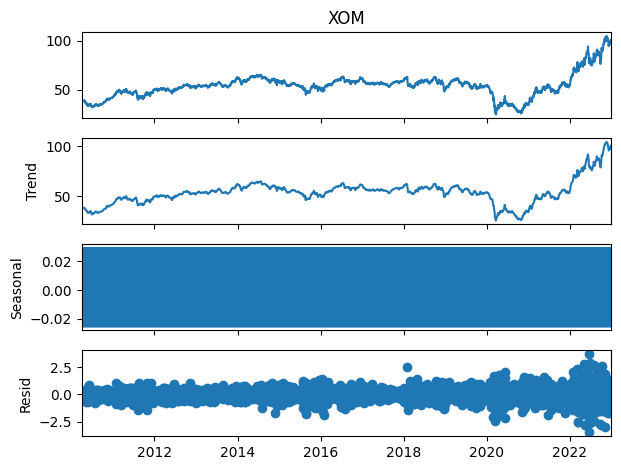

In [669]:
xom_decomposed = seasonal_decompose(df_train.XOM, model='additive')
xom_decomposed.plot().show()

In [689]:
df_train.isna().sum()

XOM              0
Crude_Oil_CLF    0
SP500            0
USD_Index        0
VIX              0
diff_xom         0
dtype: int64

In [ ]:
df_train.dropna(inplace=True)

In [691]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3326 entries, 2010-04-02 to 2022-12-30
Freq: B
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   XOM            3326 non-null   float64
 1   Crude_Oil_CLF  3326 non-null   float64
 2   SP500          3326 non-null   float64
 3   USD_Index      3326 non-null   float64
 4   VIX            3326 non-null   float64
 5   diff_xom       3326 non-null   float64
dtypes: float64(6)
memory usage: 181.9 KB


In [693]:
adf_result = adfuller(df_train.diff_xom.dropna(), regression='ct', maxlag=6, store=True)

In [695]:
adf_result

(-24.53699923306617,
 0.0,
 {'1%': -3.961499420127026,
  '5%': -3.411813230663636,
  '10%': -3.1278291518853396},
 <statsmodels.stats.diagnostic.ResultsStore at 0x15287e0f3e0>)

In [697]:
print(adf_result[-1].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     464.6
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        01:13:59   Log-Likelihood:                -4055.0
No. Observations:                3320   AIC:                             8126.
Df Residuals:                    3312   BIC:                             8175.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0488      0.043    -24.537      0.0

## ARIMA Model General - ARIMA(6, 1, 6)
#### Augmentations: 6 so p=6, q=6

In [701]:
# i = 1 because diff(1) was enough to make it stationary
model_arima_general = SARIMAX(df_train.XOM, order = (6, 1, 6))
result_arima_general = model_arima_general.fit()
print(result_arima_general.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -4053.041
Date:                Mon, 26 May 2025   AIC                           8132.082
Time:                        01:19:32   BIC                           8211.502
Sample:                    04-02-2010   HQIC                          8160.500
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2552      0.202     -1.262      0.207      -0.651       0.141
ar.L2         -0.0620      0.204     -0.303      0.762      -0.463       0.339
ar.L3         -0.3444      0.203     -1.699      0.0

## Test for Joint Significance before GETS
### Wald Test

In [715]:
print(result_arima_general.params.index)

Index(['ar.L1', 'ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ar.L6', 'ma.L1', 'ma.L2',
       'ma.L3', 'ma.L4', 'ma.L5', 'ma.L6', 'sigma2'],
      dtype='object')


In [721]:
param_names = result_arima_general.params.index
test_params = ['ar.L2', 'ar.L3', 'ar.L4', 'ar.L5', 'ar.L6']
R = np.zeros((len(test_params), len(param_names)))

for i, name in enumerate(test_params):
    idx = list(param_names).index(name)
    R[i, idx] = 1  # Restrict each to 0

# Wald test: H0: ar.L2 = ar.L3 = ... = ar.L6 = 0
wald_res = result_arima_general.wald_test(R)
print(wald_res)

<Wald test (chi2): statistic=[[578.11277269]], p-value=1.0826693257466941e-122, df_denom=5>


## Wald Test for Joint Significance (AR Lags L2–L6)

**Null Hypothesis (H₀):**  
All selected AR lag coefficients (L2 to L6) are jointly equal to zero.

**Test Result:**

- **Test Statistic (Chi²):** 578.11  
- **p-value:** 1.08 × 10⁻¹²²  
- **Degrees of Freedom:** 5

**Conclusion:**  
Since the p-value is extremely small (≪ 0.05), we **reject the null hypothesis**.  
The AR lags L2 to L6 are **jointly statistically significant** and should **not be removed** from the model.


In [703]:
# remove one order with highest p-value from p
model_arima1 = SARIMAX(df_train.XOM, order = (5, 1, 6))
result_arima1 = model_arima1.fit()
print(result_arima1.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(5, 1, 6)   Log Likelihood               -4053.333
Date:                Mon, 26 May 2025   AIC                           8130.665
Time:                        01:20:54   BIC                           8203.976
Sample:                    04-02-2010   HQIC                          8156.897
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8083      0.274     -2.952      0.003      -1.345      -0.272
ar.L2         -0.2692      0.461     -0.584      0.559      -1.173       0.634
ar.L3         -0.0479      0.480     -0.100      0.9

In [724]:
model_arima2 = SARIMAX(df_train.XOM, order = (5, 1, 5))
result_arima2 = model_arima2.fit()
print(result_arima2.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -4055.510
Date:                Mon, 26 May 2025   AIC                           8133.019
Time:                        01:32:10   BIC                           8200.221
Sample:                    04-02-2010   HQIC                          8157.065
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7058      0.208     -3.400      0.001      -1.113      -0.299
ar.L2         -0.1554      0.334     -0.466      0.642      -0.810       0.499
ar.L3          0.1007      0.348      0.289      0.7

In [726]:
model_arima3 = SARIMAX(df_train.XOM, order = (4, 1, 5))
result_arima3 = model_arima3.fit()
print(result_arima3.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -4054.322
Date:                Mon, 26 May 2025   AIC                           8128.644
Time:                        01:32:50   BIC                           8189.737
Sample:                    04-02-2010   HQIC                          8150.504
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7009      0.031    -55.386      0.000      -1.761      -1.641
ar.L2         -1.7721      0.048    -36.630      0.000      -1.867      -1.677
ar.L3         -1.5714      0.044    -35.405      0.0

In [728]:
model_arima4 = SARIMAX(df_train.XOM, order = (4, 1, 4))
result_arima4 = model_arima4.fit()
print(result_arima4.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -4054.689
Date:                Mon, 26 May 2025   AIC                           8127.378
Time:                        01:33:28   BIC                           8182.361
Sample:                    04-02-2010   HQIC                          8147.052
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1964      0.042    -28.560      0.000      -1.279      -1.114
ar.L2         -1.7637      0.051    -34.666      0.000      -1.863      -1.664
ar.L3         -1.1115      0.045    -24.491      0.0

In [730]:
resid_arima4 = result_arima4.resid

In [732]:
resid_arima4.var()

1.1033484510523182

In [734]:
resid_arima4.mean()

0.030299752239501813

In [736]:
resid_arima4.std()

1.0504039466092643

In [738]:
mae = np.mean(np.abs(resid_arima4))
mae

0.5688136726863109

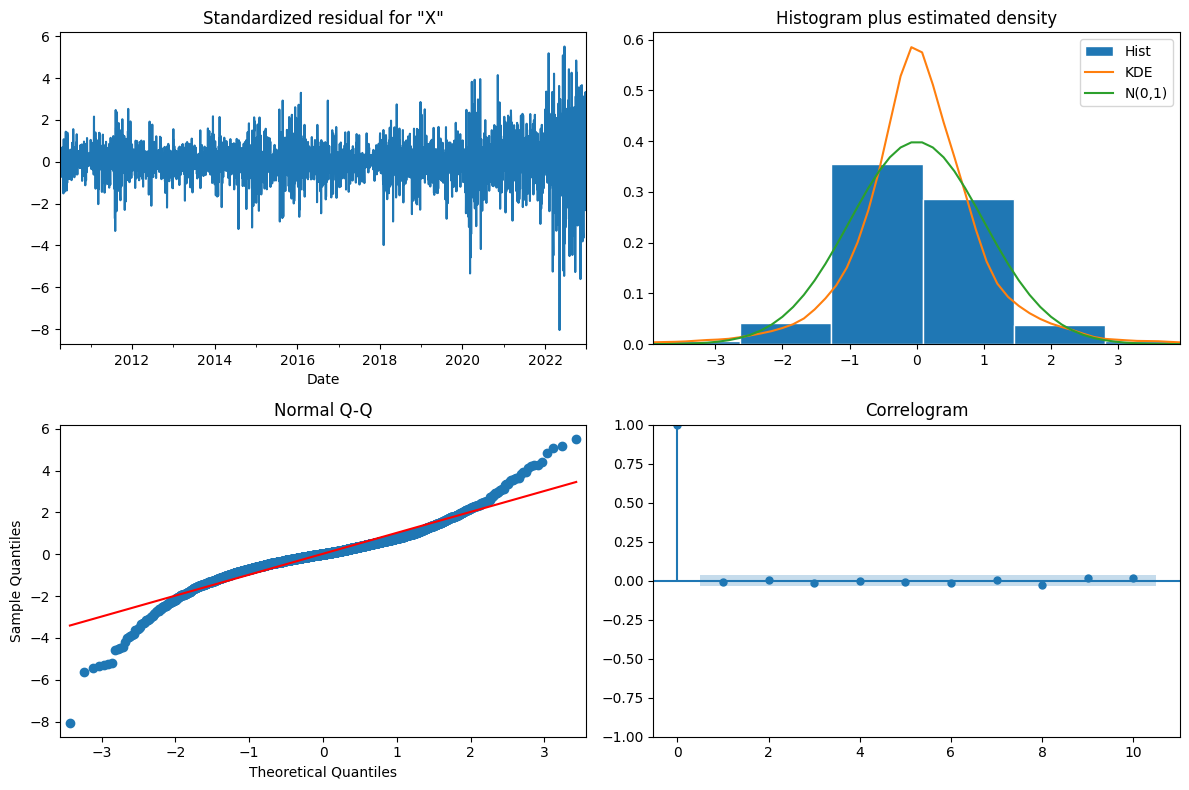

In [740]:
result_arima4.plot_diagnostics(figsize=(12, 8)); plt.tight_layout()

<Figure size 600x400 with 0 Axes>

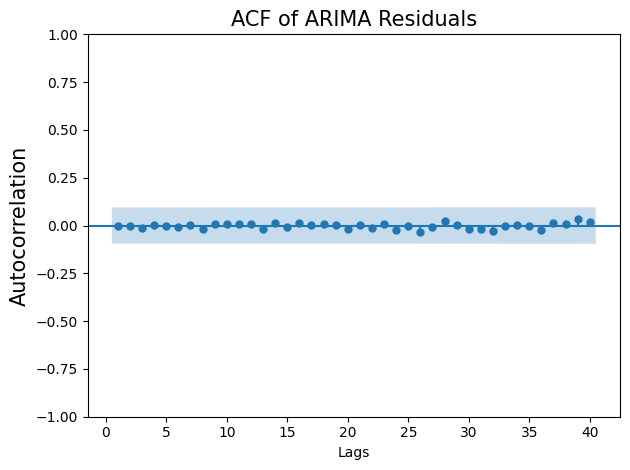

In [762]:
plt.figure(figsize=(6, 4))
plot_acf(resid_arima4.dropna(), lags=40, alpha=0.00000005, zero=False)
plt.title('ACF of ARIMA Residuals', size=15)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation', size=15)
plt.tight_layout()
plt.show()

In [764]:
'''
Residuals are not autocorrelated which means model is good.
'''

'\nResiduals are not autocorrelated which means model is good.\n'

## Breusch-Godfrey Test (for Autocorrelation)

In [769]:
residuals = result_arima4.resid
exog = result_arima4.model.exog

bg_test = smd.acorr_breusch_godfrey(result_arima4, nlags=4)
print(f"LM Statistic: {bg_test[0]}")
print(f"p-value: {bg_test[1]}")

LM Statistic: 0.5225910379872196
p-value: 0.9712648026645919


📖 Hypotheses \
Null Hypothesis (H₀): No autocorrelation in the residuals.

Alternative Hypothesis (H₁): Autocorrelation is present in the residuals.

If p-value > 0.05: Fail to reject H₀ → No significant autocorrelation.

If p-value ≤ 0.05: Reject H₀ → Autocorrelation is present in residuals.

In [774]:
'''
From Breusch-Godfrey Test Results: there is no autocorrelation in residuals.
'''

'\nFrom Breusch-Godfrey Test Results: there is no autocorrelation in residuals.\n'

## Model after GETS - ARIMA(4, 1, 4)

## Ramsey RESET, Breusch-Pagan, and White tests

### Hypotheses:

| Test            | Null Hypothesis (H₀)                                  | Alternative Hypothesis (H₁)                      |
|-----------------|------------------------------------------------------|-------------------------------------------------|
| **Ramsey RESET**    | Model is correctly specified (linear functional form) | Model is misspecified (non-linear form)          |
| **Breusch-Pagan**   | Errors have constant variance (homoscedasticity)        | Errors have non-constant variance (heteroscedasticity) |
| **White test**      | Errors are homoscedastic and no specification error      | Errors are heteroscedastic or model misspecified |

---

### Interpretation:

- If **p-value < 0.05** → reject H₀ (problem exists)  
- If **p-value ≥ 0.05** → fail to reject H₀ (no evidence of problem)


In [797]:
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white

## ARDL

In [814]:
from statsmodels.tsa.ardl import ARDL

In [836]:
# first order differencing
df_diff = df_train.diff().dropna()

In [834]:
adf_test(df_diff['XOM'], max_aug=6)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.655988,0.0,-2.567,-1.941,-1.616,0.0083,0.0013,0.0022
1,1,-40.834981,0.0,-2.567,-1.941,-1.616,0.0094,0.0014,0.0024
2,2,-35.122253,0.0,-2.567,-1.941,-1.616,0.0109,0.0316,0.0416
3,3,-28.807976,0.0,-2.567,-1.941,-1.616,0.0565,0.1114,0.1644
4,4,-25.472606,0.0,-2.567,-1.941,-1.616,0.0346,0.0994,0.1821
5,5,-24.459256,0.0,-2.567,-1.941,-1.616,0.2233,0.3853,0.6529


In [840]:
adf_test(df_diff['SP500'], max_aug=6)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-63.973031,0.0,-2.567,-1.941,-1.616,0.0285,0.0,0.0
1,1,-40.672906,0.0,-2.567,-1.941,-1.616,0.0000,0.0,0.0
2,2,-33.796984,0.0,-2.567,-1.941,-1.616,0.0000,0.0,0.0
3,3,-29.971735,0.0,-2.567,-1.941,-1.616,0.0000,0.0,0.0
4,4,-26.004259,0.0,-2.567,-1.941,-1.616,0.0000,0.0,0.0
5,5,-25.872365,0.0,-2.567,-1.941,-1.616,0.0000,0.0,0.0


In [842]:
adf_test(df_diff['Crude_Oil_CLF'], max_aug=6)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-69.805789,0.0,-2.567,-1.941,-1.616,0.0005,0.0039,0.0003
1,1,-47.674061,0.0,-2.567,-1.941,-1.616,0.3264,0.5226,0.0369
2,2,-38.123345,0.0,-2.567,-1.941,-1.616,0.9189,0.9057,0.1136
3,3,-31.834197,0.0,-2.567,-1.941,-1.616,0.8558,0.8704,0.0940
4,4,-28.278437,0.0,-2.567,-1.941,-1.616,0.6319,0.7744,0.0987
5,5,-25.562582,0.0,-2.567,-1.941,-1.616,0.3006,0.1400,0.0618


In [844]:
adf_test(df_diff['USD_Index'], max_aug=6)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-56.789841,0.0,-2.567,-1.941,-1.616,0.8215,0.2557,0.4165
1,1,-40.328808,0.0,-2.567,-1.941,-1.616,0.8925,0.2918,0.4558
2,2,-33.357645,0.0,-2.567,-1.941,-1.616,0.3714,0.1502,0.2904
3,3,-29.240390,0.0,-2.567,-1.941,-1.616,0.0526,0.1539,0.2837
4,4,-25.677956,0.0,-2.567,-1.941,-1.616,0.0533,0.1865,0.3290
5,5,-24.364028,0.0,-2.567,-1.941,-1.616,0.3902,0.5388,0.8003


In [846]:
adf_test(df_diff['VIX'], max_aug=6)

,number of augmentations,ADF test statistic,ADF p-value,ADF critical value (1%),ADF critical value (5%),ADF critical value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-68.197465,0.0,-2.567,-1.941,-1.616,0.0034,0.0003,0.0003
1,1,-44.000585,0.0,-2.567,-1.941,-1.616,0.0038,0.0003,0.0003
2,2,-35.103533,0.0,-2.567,-1.941,-1.616,0.0017,0.0003,0.0003
3,3,-32.001644,0.0,-2.567,-1.941,-1.616,0.0020,0.0265,0.0280
4,4,-28.720351,0.0,-2.567,-1.941,-1.616,0.0098,0.0054,0.0341
5,5,-26.587724,0.0,-2.567,-1.941,-1.616,0.0359,0.0236,0.0667


In [848]:
'''
Let's for now remove VIX and SP500

'''

"\nLet's for now remove VIX and SP500\n\n"

In [850]:
# Y = df_diff['XOM']
# exog = df_diff[['SP500', 'Crude_Oil_CLF', 'USD_Index', 'VIX']]
# order = list(range(1, 6))

# model_ardl_general = ARDL(endog=Y, exog=exog, lags = 6, order = order)
# result_ardl_general = model_ardl_general.fit()
# print(result_ardl_general.summary())

In [1034]:
Y = df_diff['XOM']
exog = df_diff[['Crude_Oil_CLF']]

In [982]:
Y = df_diff['XOM']
exog = df_diff[['Crude_Oil_CLF']]

model_ardl_general = ARDL(endog=Y, exog=exog, lags = 6, order = 6)
result_ardl_general = model_ardl_general.fit()
print(result_ardl_general.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(6, 6)   Log Likelihood               -3692.231
Method:               Conditional MLE   S.D. of innovations              0.736
Date:                Mon, 26 May 2025   AIC                           7414.463
Time:                        03:02:13   BIC                           7506.074
Sample:                    04-13-2010   HQIC                          7447.246
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0214      0.013      1.670      0.095      -0.004       0.047
XOM.L1              -0.0280      0.017     -1.607      0.108      -0.062       0.006
XOM.L2              -0.0427 

In [862]:
model_ardl1 = ARDL(endog=Y, exog=exog, lags = 5, order = 6)
result_ardl1 = model_ardl1.fit()
print(result_ardl1.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(5, 6)   Log Likelihood               -3694.905
Method:               Conditional MLE   S.D. of innovations              0.736
Date:                Mon, 26 May 2025   AIC                           7417.810
Time:                        02:26:03   BIC                           7503.318
Sample:                    04-13-2010   HQIC                          7448.409
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0207      0.013      1.615      0.106      -0.004       0.046
XOM.L1              -0.0293      0.017     -1.677      0.094      -0.063       0.005
XOM.L2              -0.0432 

In [864]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 4, order = 6)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(4, 6)   Log Likelihood               -3697.877
Method:               Conditional MLE   S.D. of innovations              0.737
Date:                Mon, 26 May 2025   AIC                           7421.753
Time:                        02:26:34   BIC                           7501.157
Sample:                    04-13-2010   HQIC                          7450.167
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0215      0.013      1.678      0.093      -0.004       0.047
XOM.L1              -0.0286      0.017     -1.638      0.101      -0.063       0.006
XOM.L2              -0.0458 

In [866]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 3, order = 6)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(3, 6)   Log Likelihood               -3699.033
Method:               Conditional MLE   S.D. of innovations              0.737
Date:                Mon, 26 May 2025   AIC                           7422.065
Time:                        02:26:48   BIC                           7495.365
Sample:                    04-13-2010   HQIC                          7448.295
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0219      0.013      1.711      0.087      -0.003       0.047
XOM.L1              -0.0298      0.017     -1.711      0.087      -0.064       0.004
XOM.L2              -0.0467 

In [874]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 3, order = 5)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(3, 5)   Log Likelihood               -3700.773
Method:               Conditional MLE   S.D. of innovations              0.737
Date:                Mon, 26 May 2025   AIC                           7423.546
Time:                        02:27:49   BIC                           7490.738
Sample:                    04-12-2010   HQIC                          7447.590
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0220      0.013      1.717      0.086      -0.003       0.047
XOM.L1              -0.0291      0.017     -1.669      0.095      -0.063       0.005
XOM.L2              -0.0481 

In [876]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 3, order = 4)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(3, 4)   Log Likelihood               -3701.680
Method:               Conditional MLE   S.D. of innovations              0.737
Date:                Mon, 26 May 2025   AIC                           7423.360
Time:                        02:28:17   BIC                           7484.443
Sample:                    04-09-2010   HQIC                          7445.217
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0223      0.013      1.735      0.083      -0.003       0.047
XOM.L1              -0.0298      0.017     -1.715      0.086      -0.064       0.004
XOM.L2              -0.0481 

In [888]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 2, order = 4)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(2, 4)   Log Likelihood               -3709.369
Method:               Conditional MLE   S.D. of innovations              0.739
Date:                Mon, 26 May 2025   AIC                           7436.739
Time:                        02:30:36   BIC                           7491.716
Sample:                    04-09-2010   HQIC                          7456.411
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0209      0.013      1.625      0.104      -0.004       0.046
XOM.L1              -0.0270      0.017     -1.548      0.122      -0.061       0.007
XOM.L2              -0.0459 

In [890]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 2, order = 3)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(2, 3)   Log Likelihood               -3712.918
Method:               Conditional MLE   S.D. of innovations              0.740
Date:                Mon, 26 May 2025   AIC                           7441.837
Time:                        02:30:46   BIC                           7490.706
Sample:                    04-08-2010   HQIC                          7459.323
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0209      0.013      1.627      0.104      -0.004       0.046
XOM.L1              -0.0272      0.017     -1.560      0.119      -0.061       0.007
XOM.L2              -0.0439 

In [892]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 2, order = 2)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(2, 2)   Log Likelihood               -3712.955
Method:               Conditional MLE   S.D. of innovations              0.740
Date:                Mon, 26 May 2025   AIC                           7439.911
Time:                        02:31:04   BIC                           7482.671
Sample:                    04-07-2010   HQIC                          7455.212
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0209      0.013      1.623      0.105      -0.004       0.046
XOM.L1              -0.0271      0.017     -1.560      0.119      -0.061       0.007
XOM.L2              -0.0439 

In [950]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 1, order = 2)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(1, 2)   Log Likelihood               -3716.778
Method:               Conditional MLE   S.D. of innovations              0.740
Date:                Mon, 26 May 2025   AIC                           7445.556
Time:                        02:56:50   BIC                           7482.210
Sample:                    04-07-2010   HQIC                          7458.672
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0200      0.013      1.556      0.120      -0.005       0.045
XOM.L1              -0.0260      0.017     -1.492      0.136      -0.060       0.008
Crude_Oil_CLF.L0     0.1849 

In [1036]:
model_ardl2 = ARDL(endog=Y, exog=exog, lags = 0, order = 2)
result_ardl2 = model_ardl2.fit()
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(0, 2)   Log Likelihood               -3718.511
Method:               Conditional MLE   S.D. of innovations              0.740
Date:                Mon, 26 May 2025   AIC                           7447.022
Time:                        03:13:34   BIC                           7477.569
Sample:                    04-07-2010   HQIC                          7457.952
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0195      0.013      1.517      0.129      -0.006       0.045
Crude_Oil_CLF.L0     0.1840      0.007     28.035      0.000       0.171       0.197
Crude_Oil_CLF.L1     0.0394 

### Cointegration Testing

In [898]:
from statsmodels.tsa.stattools import coint

In [901]:
score, p_value, _ = coint(Y, exog)

In [903]:
print(f'Cointegration p-value: {p_value}')

Cointegration p-value: 0.0


### 📘 Cointegration Test Interpretation

- **Null Hypothesis (H₀)**: No cointegration exists between the time series.
- **Alternative Hypothesis (H₁)**: The time series are cointegrated (i.e., there is a long-term equilibrium relationship).

#### ✅ Decision Rule:

- If **p-value < 0.05** → **Reject H₀**  
  ⇒ There **is** evidence of cointegration.

- If **p-value ≥ 0.05** → **Fail to reject H₀**  
  ⇒ There is **no** evidence of cointegration.

> Cointegration suggests that even though the individual series may be non-stationary, they move together in the long run.

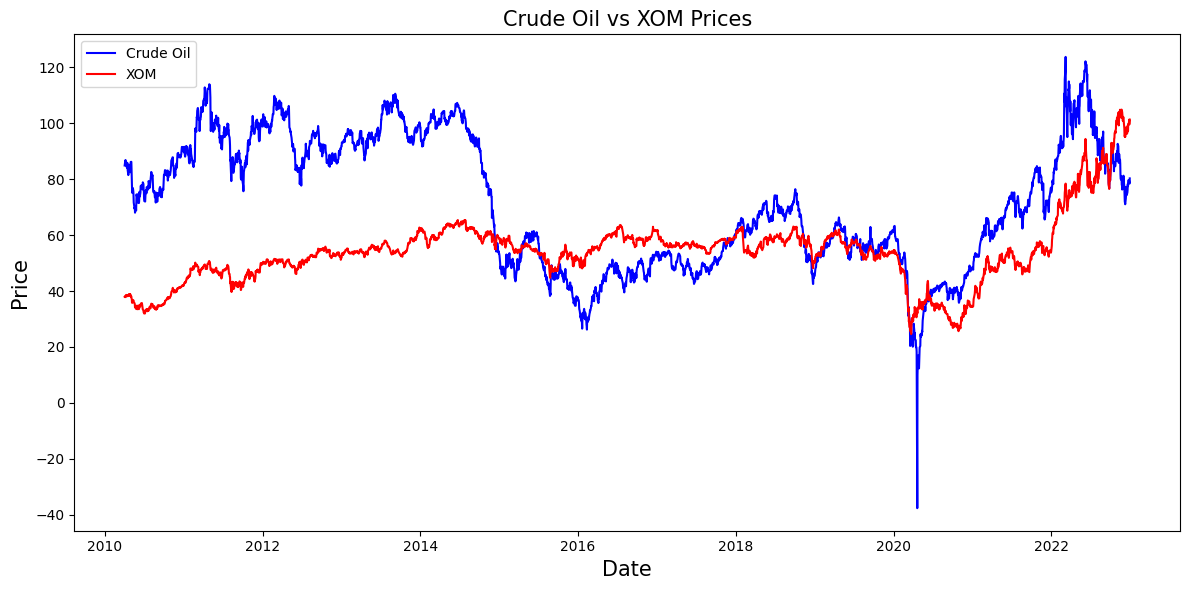

In [920]:
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['Crude_Oil_CLF'], label='Crude Oil', color='blue')
plt.plot(df_train.index, df_train['XOM'], label='XOM', color='red')
plt.title('Crude Oil vs XOM Prices', size=15)
plt.xlabel('Date', size=15)
plt.ylabel('Price', size=15)
plt.legend()
plt.tight_layout()
plt.show()

In [941]:
exog = sm.add_constant(df_diff[['Crude_Oil_CLF']].dropna())
resid = result_ardl2.resid.dropna()
exog = exog.loc[resid.index]
ols_model = sm.OLS(resid, exog).fit()
# from statsmodels.stats.diagnostic import acorr_breusch_godfrey
bg_test = acorr_breusch_godfrey(ols_model, nlags=5)

print(f"Breusch-Godfrey p-value: {bg_test[1]}")

Breusch-Godfrey p-value: 1.9952207376527054e-05


Hypotheses:

H₀: No autocorrelation

H₁: Autocorrelation exists

Interpretation:

p-value < 0.05 → autocorrelation present (bad)

p-value ≥ 0.05 → no autocorrelation (good)

In [964]:
from statsmodels.stats.diagnostic import linear_reset

# Refit residuals using OLS (since RESET only works on linear models)
ols_model = sm.OLS(resid, exog).fit()

# Ramsey RESET test
reset = linear_reset(ols_model, power=2, use_f=True)
print(f"Ramsey RESET p-value: {reset.pvalue}")

Ramsey RESET p-value: 1.0


Hypotheses:

H₀: Model is correctly specified (linear)

H₁: Model is misspecified (non-linear terms needed)

Interpretation:

p-value < 0.05 → model is misspecified

p-value ≥ 0.05 → no evidence of misspecification

In [998]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

# Breusch-Pagan Test
bp_test = het_breuschpagan(resid, exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

# White Test
white_test = het_white(resid, exog)
print(f"White test p-value: {white_test[1]}")

Breusch-Pagan p-value: 1.8772946547318133e-34
White test p-value: 0.0


Hypotheses (both tests):

H₀: Homoscedasticity (constant variance)

H₁: Heteroscedasticity (non-constant variance)

Interpretation:

p-value < 0.05 → heteroscedasticity exists

p-value ≥ 0.05 → variance is constant (good)

In [1002]:
exog = sm.add_constant(df_diff[['Crude_Oil_CLF']].dropna())
resid = result_ardl_general.resid.dropna()
exog = exog.loc[resid.index]
ols_model = sm.OLS(resid, exog).fit()
# from statsmodels.stats.diagnostic import acorr_breusch_godfrey
bg_test = acorr_breusch_godfrey(ols_model, nlags=5)

print(f"Breusch-Godfrey p-value: {bg_test[1]}")

Breusch-Godfrey p-value: 0.9999353126678401


In [986]:
# H₀: No autocorrelation

In [1004]:
ols_model = sm.OLS(resid, exog).fit()

# Ramsey RESET test
reset = linear_reset(ols_model, power=2, use_f=True)
print(f"Ramsey RESET p-value: {reset.pvalue}")

Ramsey RESET p-value: 1.0


In [1010]:
# H₁: Model is misspecified (non-linear terms needed)

In [1006]:
bp_test = het_breuschpagan(resid, exog)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

# White Test
white_test = het_white(resid, exog)
print(f"White test p-value: {white_test[1]}")

Breusch-Pagan p-value: 1.8772946547318133e-34
White test p-value: 0.0


In [1012]:
# H₁: Heteroscedasticity (non-constant variance)

<Figure size 600x400 with 0 Axes>

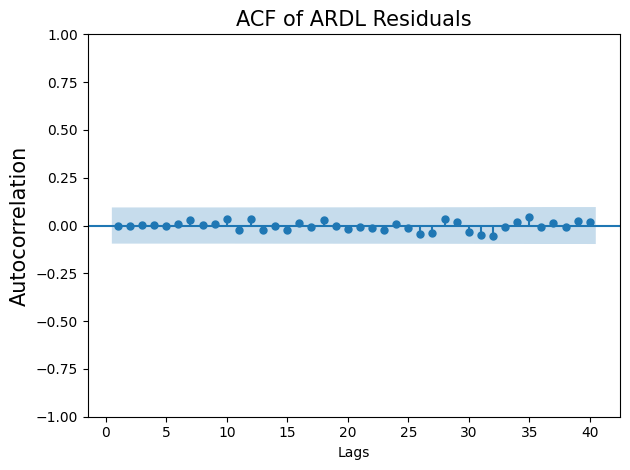

In [1016]:
plt.figure(figsize=(6, 4))
plot_acf(resid.dropna(), lags=40, alpha=0.00000005, zero=False)
plt.title('ACF of ARDL Residuals', size=15)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation', size=15)
plt.tight_layout()
plt.show()

In [1018]:
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF=1): # DF -> degrees of freedom
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [1026]:
'''
GETS Approach Specific Models

result_arima4 
result_ardl_general

'''

'\nGETS Approach Specific Models\n\nresult_arima4 \nresult_ardl_general\n\n'

In [1024]:
print(result_arima4.summary())

                               SARIMAX Results                                
Dep. Variable:                    XOM   No. Observations:                 3326
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -4054.689
Date:                Mon, 26 May 2025   AIC                           8127.378
Time:                        03:12:17   BIC                           8182.361
Sample:                    04-02-2010   HQIC                          8147.052
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1964      0.042    -28.560      0.000      -1.279      -1.114
ar.L2         -1.7637      0.051    -34.666      0.000      -1.863      -1.664
ar.L3         -1.1115      0.045    -24.491      0.0

In [1038]:
print(result_ardl2.summary())

                              ARDL Model Results                              
Dep. Variable:                    XOM   No. Observations:                 3325
Model:                     ARDL(0, 2)   Log Likelihood               -3718.511
Method:               Conditional MLE   S.D. of innovations              0.740
Date:                Mon, 26 May 2025   AIC                           7447.022
Time:                        03:16:15   BIC                           7477.569
Sample:                    04-07-2010   HQIC                          7457.952
                         - 12-30-2022                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0195      0.013      1.517      0.129      -0.006       0.045
Crude_Oil_CLF.L0     0.1840      0.007     28.035      0.000       0.171       0.197
Crude_Oil_CLF.L1     0.0394 

In [1046]:
LLR_test(model_arima4, model_ardl2, DF = 4)

0.0

In [1048]:
LLR_test(model_ardl2, model_arima4, DF = 4)

1.0

In [1052]:
model_arima4.fit().aic

8127.378021224217

In [1054]:
model_arima4.fit().bic

8182.361045802027

In [1060]:
model_ardl2.fit().aic

7447.022476545463

In [1062]:
model_ardl2.fit().bic

7477.5686013109125

In [1072]:
test_start = '2023-01-02'
test_end = '2025-04-11'

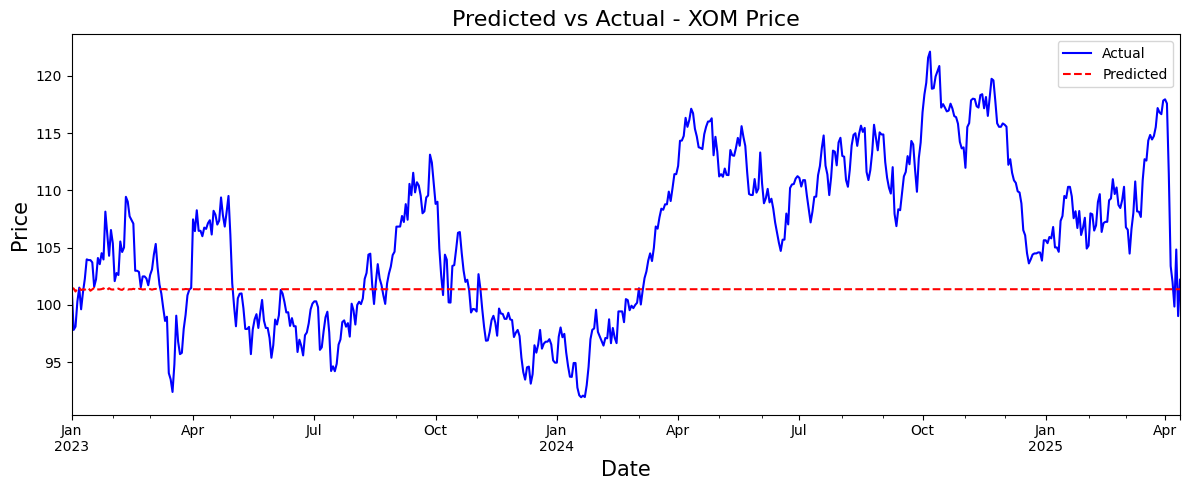

In [1088]:
dt_pred_xom = result_arima4.predict(start=test_start, end=test_end)
plt.figure(figsize=(12, 5))
df_test['XOM'].plot(label='Actual', color='blue')
dt_pred_xom.plot(label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual - XOM Price', fontsize=16)
plt.xlabel('Date', size=15)
plt.ylabel('Price', size=15)
plt.legend()
plt.tight_layout()
plt.show()